In [1]:
import numpy as np
import networkx as nx
from typing import Dict, Any, List
import random

In [2]:
from optiLib.problem import TaskGraph, NetGraph

In [3]:
RANDOM_SEED = 1
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

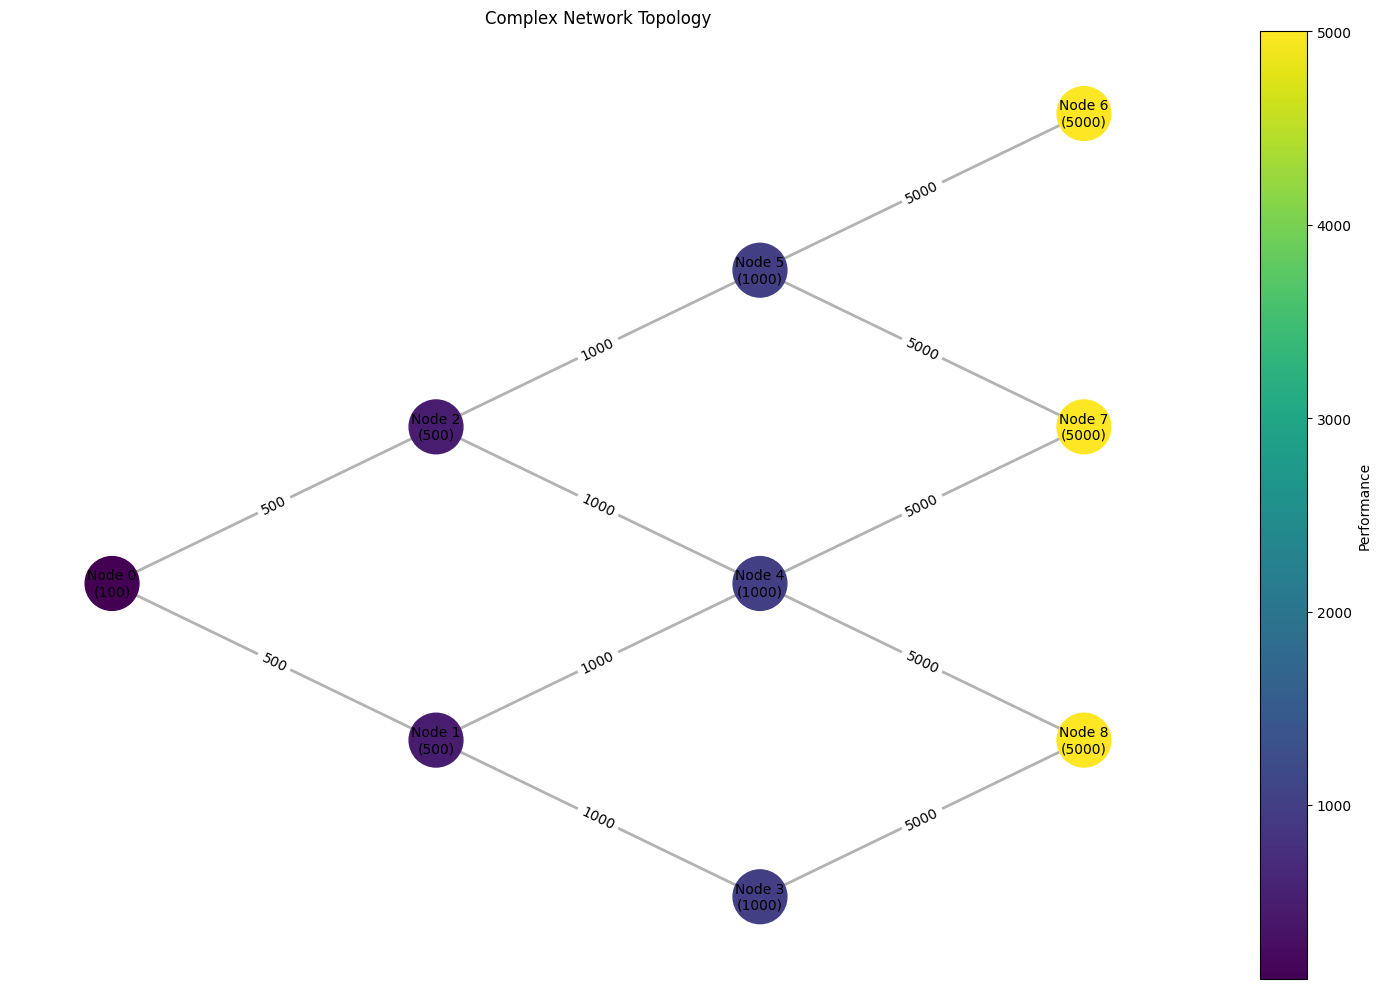


Network Properties:
Network type: Complex
Number of nodes: 9
Number of edges: 11

Nodes:
Node 0 - Performance: 100
Node 1 - Performance: 500
Node 2 - Performance: 500
Node 3 - Performance: 1000
Node 4 - Performance: 1000
Node 5 - Performance: 1000
Node 6 - Performance: 5000
Node 7 - Performance: 5000
Node 8 - Performance: 5000

Edge bandwidths:
Edge 0-2: 500
Edge 0-1: 500
Edge 1-4: 1000
Edge 1-3: 1000
Edge 2-4: 1000
Edge 2-5: 1000
Edge 3-8: 5000
Edge 4-7: 5000
Edge 4-8: 5000
Edge 5-6: 5000
Edge 5-7: 5000


In [4]:
# Создание сложной сети (первый пример)
net = NetGraph(graph_type=1)
net.visualize()
net.print_info()

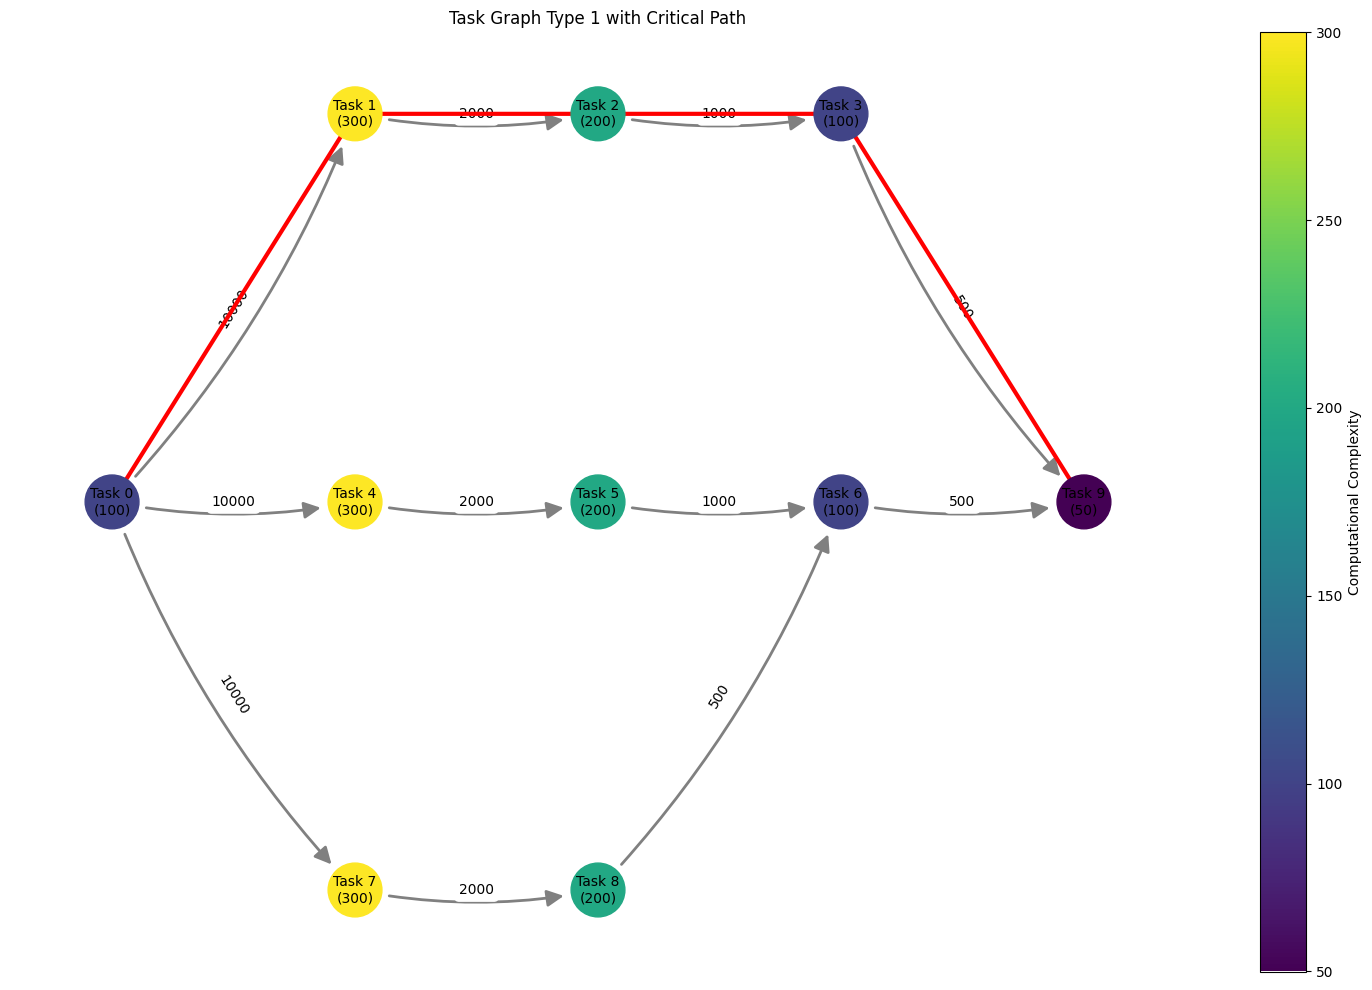


Task Graph Type 1 Properties:
Number of tasks: 10
Number of dependencies: 11
Total computational complexity: 1850
Total data transfer: 39500

Critical Path Information:
Path: 0 -> 1 -> 2 -> 3 -> 9
Length: 14250


In [5]:
task = TaskGraph(graph_type=1)
task.visualize()
task.print_info()

In [6]:
def calculate_resource_cost_without_transit(vector: list, problem) -> dict:
    """
    Расчет стоимости привлекаемых ресурсов для решения задачи с учетом энергопотребления
    и назначений задач, без учета транзитных передач.
    
    Args:
        vector: list, распределение задач по узлам
        problem: объект задачи с информацией о платформе и задачах
        
    Returns:
        dict: результаты по стоимости ресурсов, нормализованным значениям и метрикам
    """
    # Проверяем наличие расписания и анализа
    if not hasattr(problem.scheduler, 'schedule') or not problem.scheduler.schedule:
        problem.scheduler.calculate_schedule(vector)
        
    # Получаем полный анализ системы и назначения задач
    analysis = problem.scheduler.get_complete_analysis(vector)
    node_assignments = problem.scheduler.assign_tasks_to_nodes(vector)
    
    nodes = problem.network_graph.nodes
    num_nodes = len(nodes)
    
    # Инициализация базовых параметров
    B = [0] * num_nodes  # Индикатор использования узлов
    C = [node.cost for node in nodes.values()]  # Базовая стоимость узлов
    C_operation = [node.operation_cost for node in nodes.values()]  # Стоимость операций
    
    # Расчет стоимости для каждого узла
    node_costs = {}
    total_C0 = 0  # Общая базовая стоимость
    total_C_operation = 0  # Общая стоимость операций
    
    for node_id, node in enumerate(nodes):
        node_info = analysis['nodes'][node_id]
        assigned_tasks = [task_id for task_id, assigned_node 
                         in node_assignments.items() if assigned_node == node_id]
        
        # Расчет стоимости вычислений
        computation_cost = 0
        for task_id in assigned_tasks:
            task_complexity = problem.task_graph.operations[task_id].get_task_complexity()
            computation_cost += task_complexity * C_operation[node_id]
            B[node_id] = 1
        
        # Расчет стоимости только прямых передач данных
        transfer_cost = 0
        for transfer in analysis['transfers']:
            # Учитываем только передачи, где узел является источником или получателем
            if transfer['from_node'] == node_id:
                B[node_id] = 1
                transfer_cost += transfer['data_volume'] * C_operation[node_id]
            elif transfer['to_node'] == node_id:
                B[node_id] = 1
                transfer_cost += transfer['data_volume'] * C_operation[node_id]
        
        # Расчет общей стоимости узла
        base_cost = C[node_id] * B[node_id]
        operation_cost = computation_cost + transfer_cost
        
        node_costs[node_id] = {
            'base_cost': base_cost,
            'computation_cost': computation_cost,
            'transfer_cost': transfer_cost,
            'total_operation_cost': operation_cost
        }
        
        total_C0 += base_cost
        total_C_operation += operation_cost
    
    # Расчет максимально возможных стоимостей
    max_base_cost = sum(C)  # Максимальная базовая стоимость
    
    # Максимальная стоимость операций (без учета транзита)
    max_operation_cost = sum(
        problem.task_graph.operations[task_id].get_task_complexity() *  max(C_operation) 
        for task_id in problem.task_graph.operations
    )

    
    # Нормализация стоимостей
    C0_norm = total_C0 / max_base_cost if max_base_cost > 0 else 0
    C_operation_norm = total_C_operation / max_operation_cost if max_operation_cost > 0 else 0
    
    # Формирование результата
    result = {
        'node_costs': node_costs,        # Детальные затраты по узлам
        'C0': total_C0,                  # Общая базовая стоимость
        'C0_norm': C0_norm,              # Нормализованная базовая стоимость
        'total_C_operation': total_C_operation,  # Общая стоимость операций
        'C_operation_norm': C_operation_norm,    # Нормализованная стоимость операций
        'B': B,                          # Использование узлов
        'statistics': {
            'active_nodes': sum(B),      # Количество активных узлов
            'max_base_cost': max_base_cost,
            'max_operation_cost': max_operation_cost,
            'total_tasks': len(problem.task_graph.operations),
            'total_transfers': len(analysis['transfers'])
        }
    }
    
    return result

# Пример использования:
'''
cost_analysis = calculate_resource_cost_without_transit(vector, problem)

print("\nАнализ стоимости ресурсов (без учета транзита):")
print(f"Общая базовая стоимость: {cost_analysis['C0']:.2f}")
print(f"Нормализованная базовая стоимость: {cost_analysis['C0_norm']:.2f}")
print(f"Общая стоимость операций: {cost_analysis['total_C_operation']:.2f}")
print(f"Нормализованная стоимость операций: {cost_analysis['C_operation_norm']:.2f}")
print(f"Активных узлов: {cost_analysis['statistics']['active_nodes']}")

print("\nДетальный анализ по узлам:")
for node_id, costs in cost_analysis['node_costs'].items():
    print(f"\nУзел {node_id}:")
    print(f"Базовая стоимость: {costs['base_cost']:.2f}")
    print(f"Стоимость вычислений: {costs['computation_cost']:.2f}")
    print(f"Стоимость передачи: {costs['transfer_cost']:.2f}")
    print(f"Общая стоимость операций: {costs['total_operation_cost']:.2f}")
'''


'\ncost_analysis = calculate_resource_cost_without_transit(vector, problem)\n\nprint("\nАнализ стоимости ресурсов (без учета транзита):")\nprint(f"Общая базовая стоимость: {cost_analysis[\'C0\']:.2f}")\nprint(f"Нормализованная базовая стоимость: {cost_analysis[\'C0_norm\']:.2f}")\nprint(f"Общая стоимость операций: {cost_analysis[\'total_C_operation\']:.2f}")\nprint(f"Нормализованная стоимость операций: {cost_analysis[\'C_operation_norm\']:.2f}")\nprint(f"Активных узлов: {cost_analysis[\'statistics\'][\'active_nodes\']}")\n\nprint("\nДетальный анализ по узлам:")\nfor node_id, costs in cost_analysis[\'node_costs\'].items():\n    print(f"\nУзел {node_id}:")\n    print(f"Базовая стоимость: {costs[\'base_cost\']:.2f}")\n    print(f"Стоимость вычислений: {costs[\'computation_cost\']:.2f}")\n    print(f"Стоимость передачи: {costs[\'transfer_cost\']:.2f}")\n    print(f"Общая стоимость операций: {costs[\'total_operation_cost\']:.2f}")\n'

In [7]:
def calculate_energy_consumption_without_transit(vector: list, problem) -> dict:
    """
    Рассчитывает энергозатраты на решение задачи без учета транзитных передач,
    используя vector распределения задач
    """
    # Проверяем наличие расписания и анализа
    if not hasattr(problem.scheduler, 'schedule') or not problem.scheduler.schedule:
        problem.scheduler.calculate_schedule(vector)

        
    analysis = problem.scheduler.get_complete_analysis(vector)
    node_assignments = problem.scheduler.assign_tasks_to_nodes(vector)
    
    results = {
        'node_energy': {},
        'total_energy': 0,
        'normalized_energy': {},
        'total_normalized_energy': 0
    }
    
    nodes = problem.network_graph.nodes
    task_graph = problem.task_graph.graph
    
    # Для каждого узла рассчитываем энергозатраты
    for node_id, node in nodes.items():
        # Энергия на вычисления
        E_comp = 0
        assigned_tasks = [task_id for task_id, assigned_node 
                         in node_assignments.items() if assigned_node == node_id]
        
        for task_id in assigned_tasks:
            task_complexity = problem.task_graph.operations[task_id].get_task_complexity()
            E_comp += task_complexity * node.e_comp
        
        # Энергия только на прямые передачи
        E_receive = 0
        E_send = 0
        
        # Учитываем только прямые передачи
        for transfer in analysis['transfers']:
            if transfer['from_node'] == node_id:
                # Узел является отправителем
                E_send += transfer['data_volume'] * node.e_send
            elif transfer['to_node'] == node_id:
                # Узел является получателем
                E_receive += transfer['data_volume'] * node.e_receive
        
        E_total = E_comp + E_receive + E_send
        
        results['node_energy'][node_id] = {
            'receive': E_receive,
            'compute': E_comp,
            'send': E_send,
            'total': E_total
        }
    
    # Расчет максимальных возможных энергозатрат
    max_compute_energy = max(node.e_comp for node in nodes.values())
    max_receive_energy = max(node.e_receive for node in nodes.values())
    max_send_energy = max(node.e_send for node in nodes.values())
    
    total_operations = analysis['statistics']['total_operations']
    total_data = analysis['statistics']['total_data_transferred']
    
    E_max = (
        total_operations * max_compute_energy +
        total_data * (max_receive_energy + max_send_energy)
    )
    
    # Расчет общих энергозатрат
    results['total_energy'] = sum(
        node['total'] for node in results['node_energy'].values()
    )
    
    # Нормализация
    for node_id in results['node_energy']:
        results['normalized_energy'][node_id] = (
            results['node_energy'][node_id]['total'] / E_max if E_max > 0 else 0
        )
    
    results['total_normalized_energy'] = results['total_energy'] / E_max if E_max > 0 else 0
    
    return results

# Пример использования:
'''
# Без учета транзита
energy_without_transit = calculate_energy_consumption_without_transit(vector, problem)
print("\nЭнергозатраты без учета транзита:")
for node_id, energy in energy_without_transit['node_energy'].items():
    print(f"\nУзел {node_id}:")
    print(f"Энергия вычислений: {energy['compute']:.2f}")
    print(f"Энергия приема: {energy['receive']:.2f}")
    print(f"Энергия отправки: {energy['send']:.2f}")
    print(f"Общая энергия: {energy['total']:.2f}")
'''


'\n# Без учета транзита\nenergy_without_transit = calculate_energy_consumption_without_transit(vector, problem)\nprint("\nЭнергозатраты без учета транзита:")\nfor node_id, energy in energy_without_transit[\'node_energy\'].items():\n    print(f"\nУзел {node_id}:")\n    print(f"Энергия вычислений: {energy[\'compute\']:.2f}")\n    print(f"Энергия приема: {energy[\'receive\']:.2f}")\n    print(f"Энергия отправки: {energy[\'send\']:.2f}")\n    print(f"Общая энергия: {energy[\'total\']:.2f}")\n'

In [8]:
def calculate_reliability_and_load_balancing(vector: List[int], problem: Any, tau: float = 1, k: float = 1) -> Dict[str, Any]:
    """
    Расчет надежности системы и балансировки нагрузки на основе временных характеристик,
    без учета транзитных передач между узлами
    """
    # Проверяем наличие расписания и анализа
    if not hasattr(problem.scheduler, 'schedule') or not problem.scheduler.schedule:
        problem.scheduler.calculate_schedule(vector)
        
    # Получаем полный анализ системы
    analysis = problem.scheduler.get_complete_analysis(vector)
    
    num_nodes = len(problem.scheduler.net_graph.nodes)
    nodes = problem.scheduler.net_graph.nodes
    
    # Получаем общее время выполнения всех задач
    total_time = analysis['statistics']['total_time']
    
    # Расчет нагрузки и надежности для каждого узла
    node_loads = np.zeros(num_nodes)  # D_i
    node_reliability = np.zeros(num_nodes)  # P_i
    node_metrics = []
    
    for node_id in range(num_nodes):
        node_info = analysis['nodes'][node_id]
        
        # Учитываем только прямые операции узла:
        # - время вычислений
        # - время отправки данных непосредственно с узла
        # - время приема данных непосредственно узлом
        compute_time = node_info['working_time']
        
        # Получаем времена передачи только для прямых соединений
        send_time = 0
        receive_time = 0
        
        # Проходим по всем передачам и учитываем только прямые
        for transfer in analysis['transfers']:
            if transfer['from_node'] == node_id:
                # Учитываем только отправку с текущего узла
                duration = transfer['end_time'] - transfer['start_time']
                send_time += duration
            elif transfer['to_node'] == node_id:
                # Учитываем только прием текущим узлом
                duration = transfer['end_time'] - transfer['start_time']
                receive_time += duration
        
        # Общее активное время узла
        active_time = compute_time + send_time + receive_time
        
        # Время простоя
        idle_time = total_time - active_time
        
        # Расчет загруженности узла (D_i)
        node_loads[node_id] = active_time / total_time if total_time > 0 else 0
        
        # Расчет надежности узла (P_i)
        lambda_0i = nodes[node_id].failure_rate
        Di = node_loads[node_id]
        node_reliability[node_id] = np.exp(-lambda_0i * tau * (2 ** (k * Di / 10)))
        
        # Сохраняем метрики узла
        node_metrics.append({
            'node_id': node_id,
            'compute_time': compute_time,
            'send_time': send_time,
            'receive_time': receive_time,
            'active_time': active_time,
            'idle_time': idle_time,
            'load': Di,
            'reliability': node_reliability[node_id]
        })
    
    # Общая надежность системы (произведение надежностей всех узлов)
    P0 = np.prod(node_reliability)
    
       
    data_array = np.array(node_loads)
    
    # Фильтруем значения меньше 0.0001 (считаем их нулевой нагрузкой)
    non_zero_data = data_array[data_array >= 0.0001]
    
    if non_zero_data.size == 0:
        return {"message": "Нет значений для анализа"}
    
    # Вычисляем статистики
    mean_val = np.mean(non_zero_data)
    variance_val = np.var(non_zero_data)
    std_dev_val = np.std(non_zero_data)
    
    # Максимально возможное стандартное отклонение для диапазона [0.0001, 1]
    max_std = 0.5

    # Нормализация (1 = максимальная близость, 0 = максимальный разброс)
    normalized_closeness = 1 - (std_dev_val / max_std)
    normalized_closeness = np.clip(normalized_closeness, 0, 1)
    
    # Формирование результата
    result = {
        "P_0": float(P0),                    # Общая надежность системы
        "D": node_loads.tolist(),            # Загруженность узлов
        "Δ": float(normalized_closeness),          # Коэффициент вариации нагрузки
        "detailed_analysis": {
            "total_time": total_time,        # Общее время выполнения
            "node_metrics": node_metrics,     # Детальные метрики по узлам
            "system_metrics": {
                "mean_load": float(mean_val),
                "std_load": float(std_dev_val),
                "min_load": float(np.min(node_loads)),
                "max_load": float(np.max(node_loads)),
                "node_reliability": node_reliability.tolist()
            }
        }
    }
    
    return result

# Пример использования:
'''
result = calculate_reliability_and_load_balancing(
    vector, 
    problem, 
    tau=1.0, 
    k=2.0
)

print(f"Общая надежность системы (P0): {result['P_0']:.4f}")
print(f"Коэффициент вариации нагрузки (Δ): {result['Δ']:.4f}")

print("\nДетальный анализ по узлам:")
for metrics in result['detailed_analysis']['node_metrics']:
    print(f"\nУзел {metrics['node_id']}:")
    print(f"Время вычислений: {metrics['compute_time']:.2f}")
    print(f"Время отправки: {metrics['send_time']:.2f}")
    print(f"Время приема: {metrics['receive_time']:.2f}")
    print(f"Общее активное время: {metrics['active_time']:.2f}")
    print(f"Время простоя: {metrics['idle_time']:.2f}")
    print(f"Загруженность (Di): {metrics['load']:.2%}")
    print(f"Надежность узла (Pi): {metrics['reliability']:.4f}")
'''


'\nresult = calculate_reliability_and_load_balancing(\n    vector, \n    problem, \n    tau=1.0, \n    k=2.0\n)\n\nprint(f"Общая надежность системы (P0): {result[\'P_0\']:.4f}")\nprint(f"Коэффициент вариации нагрузки (Δ): {result[\'Δ\']:.4f}")\n\nprint("\nДетальный анализ по узлам:")\nfor metrics in result[\'detailed_analysis\'][\'node_metrics\']:\n    print(f"\nУзел {metrics[\'node_id\']}:")\n    print(f"Время вычислений: {metrics[\'compute_time\']:.2f}")\n    print(f"Время отправки: {metrics[\'send_time\']:.2f}")\n    print(f"Время приема: {metrics[\'receive_time\']:.2f}")\n    print(f"Общее активное время: {metrics[\'active_time\']:.2f}")\n    print(f"Время простоя: {metrics[\'idle_time\']:.2f}")\n    print(f"Загруженность (Di): {metrics[\'load\']:.2%}")\n    print(f"Надежность узла (Pi): {metrics[\'reliability\']:.4f}")\n'

In [9]:
def calculate_migration_metrics(vector: list, problem) -> dict:
    '''
    Рассчитывает метрики миграции задач с нулевого узла согласно вектору распределения
    
    Args:
        vector (list): Вектор распределения задач по узлам (индекс = id задачи, значение = id узла)
        problem (Problem): Объект задачи с информацией о сети и задачах
        
    Returns:
        dict: Метрики миграции:
            - M_total: Общие затраты на миграцию
            - M_norm: Нормализованные затраты [0,1]
            - migration_paths: Информация о путях миграции
            - migration_tasks: Информация о миграции задач
            - migration_stats: Статистика миграции
    '''
    # Проверяем наличие расписания и анализа
    if not hasattr(problem.scheduler, 'schedule') or not problem.scheduler.schedule:
        problem.scheduler.calculate_schedule(vector)
        
    # Получаем граф сети
    network = problem.network_graph.graph
    
    # Рассчитываем кратчайшие пути от нулевого узла
    shortest_paths = nx.single_source_dijkstra_path(
        network, 
        source=0,
        weight='weight'
    )
    shortest_paths_lengths = nx.single_source_dijkstra_path_length(
        network,
        source=0,
        weight='weight'  
    )
    
    M_total = 0  # Общие затраты на миграцию
    migration_paths = {}  # Информация о путях к каждому узлу
    migration_tasks = {}  # Информация о миграции задач
    
    # Группируем задачи по узлам назначения
    nodes_tasks = {}
    for task_id, node_id in enumerate(vector):
        if node_id != 0:
            if node_id not in nodes_tasks:
                nodes_tasks[node_id] = []
            nodes_tasks[node_id].append(task_id)
    
    # Для каждого узла назначения
    for node_id, tasks in nodes_tasks.items():
        node_migration_cost = 0
        node_tasks = []
        path_length = shortest_paths_lengths[node_id]
        
        # Обрабатываем каждую задачу для этого узла
        for task_id in tasks:
            task = problem.task_graph.operations[task_id]
            task_volume = task.get_task_complexity()
            
            # Стоимость миграции задачи
            task_migration_cost = path_length * task_volume
            node_migration_cost += task_migration_cost
            
            # Сохраняем информацию о миграции задачи
            task_info = {
                'target_node': node_id,
                'path': shortest_paths[node_id],
                'volume': task_volume,
                'migration_cost': task_migration_cost
            }
            migration_tasks[task_id] = task_info
            
            node_tasks.append({
                'task_id': task_id,
                'volume': task_volume,
                'migration_cost': task_migration_cost
            })
            
        if node_tasks:
            migration_paths[node_id] = {
                'path': shortest_paths[node_id],
                'length': path_length,
                'total_node_cost': node_migration_cost,
                'tasks': node_tasks
            }
            M_total += node_migration_cost
    
    # Нормализация
    max_path_length = max(shortest_paths_lengths.values())
    total_task_volume = sum(task.get_task_complexity() 
                           for task in problem.task_graph.operations.values())
    max_possible_migration_cost = max_path_length * total_task_volume
    
    M_norm = M_total / max_possible_migration_cost if max_possible_migration_cost > 0 else 0
    
    # Собираем статистику
    migrated_task_count = len(migration_tasks)
    total_migrated_volume = sum(info['volume'] for info in migration_tasks.values())
    migration_lengths = [info['length'] for info in migration_paths.values()]
    
    return {
        'M_total': float(M_total),  # Общие затраты на миграцию
        'M_norm': float(M_norm),    # Нормализованные затраты
        'migration_paths': migration_paths,  # Информация о путях миграции
        'migration_tasks': migration_tasks,  # Информация о задачах
        'migration_stats': {
            'migrated_task_count': migrated_task_count,
            'total_migrated_volume': float(total_migrated_volume),
            'max_migration_path': float(max(migration_lengths)) if migration_lengths else 0,
            'avg_migration_path': float(np.mean(migration_lengths)) if migration_lengths else 0,
            'migration_paths_count': len(migration_paths),
            'max_possible_cost': float(max_possible_migration_cost)
        }
    }

'''
migration_metrics = calculate_migration_metrics(vector, problem)

print(f"M_total (общие затраты): {migration_metrics['M_total']:.2f}")
print(f"M_norm (нормализованные затраты): {migration_metrics['M_norm']:.4f}")

print("\nСтатистика миграции:")
stats = migration_metrics['migration_stats']
print(f"Количество задач: {stats['migrated_task_count']}")
print(f"Общий объем: {stats['total_migrated_volume']:.2f}")
print(f"Макс. длина пути: {stats['max_migration_path']}")
print(f"Средняя длина пути: {stats['avg_migration_path']:.2f}")

print("\nПути миграции:")
for node_id, info in migration_metrics['migration_paths'].items():
    print(f"\nУзел {node_id}:")
    print(f"Путь: {info['path']}")
    print(f"Длина: {info['length']}")
    print(f"Стоимость: {info['total_node_cost']:.2f}")
    print("Задачи:")
    for task in info['tasks']:
        print(f"  Задача {task['task_id']}: "
              f"объем={task['volume']}, "
              f"стоимость={task['migration_cost']:.2f}")
'''


'\nmigration_metrics = calculate_migration_metrics(vector, problem)\n\nprint(f"M_total (общие затраты): {migration_metrics[\'M_total\']:.2f}")\nprint(f"M_norm (нормализованные затраты): {migration_metrics[\'M_norm\']:.4f}")\n\nprint("\nСтатистика миграции:")\nstats = migration_metrics[\'migration_stats\']\nprint(f"Количество задач: {stats[\'migrated_task_count\']}")\nprint(f"Общий объем: {stats[\'total_migrated_volume\']:.2f}")\nprint(f"Макс. длина пути: {stats[\'max_migration_path\']}")\nprint(f"Средняя длина пути: {stats[\'avg_migration_path\']:.2f}")\n\nprint("\nПути миграции:")\nfor node_id, info in migration_metrics[\'migration_paths\'].items():\n    print(f"\nУзел {node_id}:")\n    print(f"Путь: {info[\'path\']}")\n    print(f"Длина: {info[\'length\']}")\n    print(f"Стоимость: {info[\'total_node_cost\']:.2f}")\n    print("Задачи:")\n    for task in info[\'tasks\']:\n        print(f"  Задача {task[\'task_id\']}: "\n              f"объем={task[\'volume\']}, "\n              f"стои

In [10]:
def convert_vector_to_tuple(vector):
    """
    Конвертирует numpy array в tuple для хэширования
    """
    if isinstance(vector, np.ndarray):
        return tuple(vector.flatten())
    return tuple(vector)

# CASE 1: Без учета транзита
def case_1_f1_cost(vector, problem) -> float:
    """
    Критерий оптимизации f1 - стоимость (без транзита)
    """
    vector_tuple = convert_vector_to_tuple(vector)
    cost_analysis = calculate_resource_cost_without_transit(vector_tuple, problem)
    return float(cost_analysis['C0'] + cost_analysis['total_C_operation'])

def case_1_f2_total_energy(vector, problem) -> float:
    """
    Критерий оптимизации f2 - энергопотребление (без транзита)
    """
    vector_tuple = convert_vector_to_tuple(vector)
    energy = calculate_energy_consumption_without_transit(vector_tuple, problem)
    return float(energy['total_energy'])

def case_1_f3_M_total(vector, problem) -> float:
    """
    Критерий оптимизации f3 - общее время выполнения (без транзита)
    """
    vector_tuple = convert_vector_to_tuple(vector)
    migration = calculate_migration_metrics(vector_tuple, problem)
    return float(migration['M_total'])

def case_1_f4_reliability(vector, problem) -> float:
    """
    Критерий оптимизации f4 - надежность (без нормализации)
    """
    vector_tuple = convert_vector_to_tuple(vector)
    reliability = calculate_reliability_and_load_balancing(vector_tuple, problem)
    return float(reliability['P_0'])

def case_1_f5_load_balance(vector, problem, max_variation=1.0) -> float:
    """
    Критерий оптимизации f5 - нормализованная балансировка нагрузки
    """
    vector_tuple = convert_vector_to_tuple(vector)
    load_balance = calculate_reliability_and_load_balancing(vector_tuple, problem)
    return float(load_balance['Δ'] / max_variation)

In [11]:
import numpy as np

def calculate_balance_metrics(array):
    """
    Расчет метрик балансировки для массива со значениями от 0 до 1
    """
    # Проверка диапазона значений
    if not all(0 <= x <= 1 for x in array):
        raise ValueError("Все элементы должны быть в диапазоне [0, 1]")
    
    arr = np.array(array)
    n = len(arr)
    
    # Базовые статистики
    mean = np.mean(arr)
    if mean == 0:
        return {
            'variation_coef': 0,
            'balance_score': 0,
            'utilization': 0
        }
    
    std = np.std(arr)
    
    # 1. Коэффициент вариации (показывает относительный разброс)
    cv = std / mean
    
    # 2. Оценка баланса (насколько равномерно распределена нагрузка)
    # Нормализованный коэффициент вариации для диапазона [0,1]
    max_possible_cv = np.sqrt((n-1)/n)  # максимально возможный CV для диапазона [0,1]
    balance_score = 1 - (cv / max_possible_cv if max_possible_cv != 0 else 0)
    
    # 3. Коэффициент утилизации (насколько эффективно используется диапазон)
    utilization = mean
    
    return {
        'variation_coef': cv,
        'balance_score': balance_score,
        'utilization': utilization
    }

def interpret_metrics(metrics):
    """
    Интерпретация полученных метрик
    """
    interpretation = {
        'balance_quality': 'Хорошая' if metrics['balance_score'] > 0.8 else 
                         'Средняя' if metrics['balance_score'] > 0.5 else 
                         'Плохая',
        'utilization_quality': 'Высокая' if metrics['utilization'] > 0.7 else 
                             'Средняя' if metrics['utilization'] > 0.4 else 
                             'Низкая'
    }
    return interpretation

# Пример использования
if __name__ == "__main__":
    # Пример хорошо сбалансированной нагрузки
    balanced = np.array([0.7, 0.75, 0.72, 0.68, 0.71])
    
    # Пример плохо сбалансированной нагрузки
    unbalanced = np.array([0.1, 0.9, 0.2, 0.95, 0.15])
    
    print("Сбалансированный массив:")
    balanced_metrics = calculate_balance_metrics(balanced)
    print("Метрики:", balanced_metrics)
    print("Интерпретация:", interpret_metrics(balanced_metrics))
    
    print("\nНесбалансированный массив:")
    unbalanced_metrics = calculate_balance_metrics(unbalanced)
    print("Метрики:", unbalanced_metrics)
    print("Интерпретация:", interpret_metrics(unbalanced_metrics))


Сбалансированный массив:
Метрики: {'variation_coef': np.float64(0.03251639579435455), 'balance_score': np.float64(0.9636455643102675), 'utilization': np.float64(0.712)}
Интерпретация: {'balance_quality': 'Хорошая', 'utilization_quality': 'Высокая'}

Несбалансированный массив:
Метрики: {'variation_coef': np.float64(0.8289424332581574), 'balance_score': np.float64(0.07321418490033871), 'utilization': np.float64(0.45999999999999996)}
Интерпретация: {'balance_quality': 'Плохая', 'utilization_quality': 'Средняя'}


In [12]:
def c1_time_limit(vector, problem):
    """
    Проверка на ограничение по времени
    """
    # Проверяем наличие расписания и анализа
    if not hasattr(problem.scheduler, 'schedule') or not problem.scheduler.schedule:
        problem.scheduler.calculate_schedule(vector)

    analysis = problem.scheduler.get_complete_analysis(vector)
    time = analysis['statistics']['total_time']
    return bool(time <= problem.t_lim)

def c2_Di(vector, problem):
    """
    Проверка на ограничение на первый узел 
    """
    analysis = calculate_reliability_and_load_balancing(vector, problem)
    D =  analysis['D']
    return all(di < 0.75 for di in D)

In [13]:
from optiLib import NetworkOptimizationProblem

problem = NetworkOptimizationProblem(net, task, f_objective=[case_1_f1_cost, case_1_f2_total_energy, case_1_f3_M_total, case_1_f4_reliability, case_1_f5_load_balance], constraints=[c1_time_limit, c2_Di], t_lim=50, name="CASE1")

In [14]:
from IPython.display import clear_output
import random

for exp in range(0, 20):
    print(f"Эксперемент {exp}")
    RANDOM_SEED = exp
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)

    from optiLib.optimizers import RandomSearchOptimizer, ParticleSwarmOptimizer

    # Инициализация оптимизатора
    optimizer = ParticleSwarmOptimizer(problem, inertia = 1.7,cognitive = 2.5 , social = 1.5, num_particles=10, iterations=1000, update_history_coef = 100)

    # Запуск оптимизации
    best_solution, best_value = optimizer.optimize()

    from optiLib.helpers import print_solution
    print_solution(best_solution, best_value)
    print(len(optimizer.history))
    if len(optimizer.history)>0:
        optimizer.save(exp)
    
    clear_output(wait=True)

Эксперемент 19


Optimizing:   6%|▋         | 64/1000 [00:00<00:03, 275.91it/s]c:\Users\meon4\Documents\MATH\Новые расчеты\optiLib\optimizers.py:113: RuntimeWarning: invalid value encountered in cast
  self.position += self.velocity.astype(self.problem.dtype)
Optimizing: 100%|██████████| 1000/1000 [00:01<00:00, 687.02it/s]


Лучшее решение: [0 0 0 8 0 0 0 0 0 0]
Значение целевой функции: 4294140231345.7173
100
Данные сохранены в файл: ./data/CASE1PSO.xlsx


In [15]:
# Нормализованные версии CASE 1
def case_1_f1_cost_norm(vector, problem) -> float:
    """
    Нормализованный критерий оптимизации f1 - стоимость (без транзита)
    """
    vector_tuple = convert_vector_to_tuple(vector)
    cost_analysis = calculate_resource_cost_without_transit(vector_tuple, problem)
    return float((cost_analysis['C0_norm'] + cost_analysis['C_operation_norm']) / 2)

def case_1_f2_total_energy_norm(vector, problem) -> float:
    """
    Критерий оптимизации f2 - энергопотребление (без транзита)
    """
    vector_tuple = convert_vector_to_tuple(vector)
    reliability_analysis = calculate_energy_consumption_without_transit(vector_tuple, problem)
    return float(reliability_analysis['total_normalized_energy'])

def case_1_f3_M_total_norm(vector, problem) -> float:
    """
    Нормализованный критерий оптимизации f3 - общее время выполнения (без транзита)
    """
    vector_tuple = convert_vector_to_tuple(vector)
    migration = calculate_migration_metrics(vector_tuple, problem)
    return float(migration['M_norm'])

def case_1_f4_reliability_norm(vector, problem, max_reliability=1.0) -> float:
    """
    Критерий оптимизации f4 - нормализованная надежность
    """
    vector_tuple = convert_vector_to_tuple(vector)
    reliability = calculate_reliability_and_load_balancing(vector_tuple, problem)
    return float(reliability['P_0'] / max_reliability)

def case_1_f5_load_balance_norm(vector, problem, max_variation=1.0) -> float:
    """
    Критерий оптимизации f5 - нормализованная балансировка нагрузки
    """
    vector_tuple = convert_vector_to_tuple(vector)
    load_balance = calculate_reliability_and_load_balancing(vector_tuple, problem)
    return float(load_balance['Δ'] / max_variation)

In [16]:
from optiLib import NetworkOptimizationProblem

problem_norm = NetworkOptimizationProblem(net, task, f_objective=[case_1_f1_cost_norm, case_1_f2_total_energy_norm, case_1_f3_M_total_norm, case_1_f4_reliability_norm, case_1_f5_load_balance_norm], constraints=[c1_time_limit, c2_Di], t_lim=50, name="CASE1_norm")

In [17]:
from IPython.display import clear_output
import random

for exp in range(0, 20):
    print(f"Эксперемент {exp}")
    RANDOM_SEED = exp
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)

    from optiLib.optimizers import RandomSearchOptimizer, ParticleSwarmOptimizer

    # Инициализация оптимизатора
    optimizer = ParticleSwarmOptimizer(problem_norm, inertia = 1.7,cognitive = 2.5 , social = 1.5, num_particles=10, iterations=1000, update_history_coef = 100)

    # Запуск оптимизации
    best_solution, best_value = optimizer.optimize()

    from optiLib.helpers import print_solution
    print_solution(best_solution, best_value)
    print(len(optimizer.history))
    if len(optimizer.history)>0:
        optimizer.save(exp)
    
    clear_output(wait=True)

Эксперемент 19


Optimizing:   6%|▌         | 62/1000 [00:00<00:03, 275.31it/s]c:\Users\meon4\Documents\MATH\Новые расчеты\optiLib\optimizers.py:113: RuntimeWarning: invalid value encountered in cast
  self.position += self.velocity.astype(self.problem.dtype)
Optimizing: 100%|██████████| 1000/1000 [00:01<00:00, 656.23it/s]


Лучшее решение: [0 0 0 8 0 0 0 0 0 0]
Значение целевой функции: 0.010094625461349503
100
Данные сохранены в файл: ./data/CASE1_normPSO.xlsx


In [18]:
1/0

ZeroDivisionError: division by zero

In [ ]:
solution = problem.generate_random_solution()
solution

In [ ]:
solution = [0,0,0,0,0,0,0,0,0,8]


In [ ]:
result = calculate_reliability_and_load_balancing(
    solution, 
    problem
)

print(f"Общая надежность системы (P0): {result['P_0']:.4f}")
print(f"Коэффициент вариации нагрузки (Δ): {result['Δ']:.4f}")
print("\nДетальный анализ по узлам:")
for metrics in result['detailed_analysis']['node_metrics']:
    print(f"\nУзел {metrics['node_id']}:")
    print(f"Время вычислений: {metrics['compute_time']:.2f}")
    print(f"Время передачи: {metrics['send_time']:.2f}")
    print(f"Время приема: {metrics['receive_time']:.2f}")
    print(f"Время простоя: {metrics['idle_time']:.2f}")
    print(f"Загруженность (Di): {metrics['load']:.2%}")
    print(f"Надежность узла (Pi): {metrics['reliability']:.4f}")

Общая надежность системы (P0): 1.0000
Коэффициент вариации нагрузки (Δ): 0.6331

Детальный анализ по узлам:

Узел 0:
Время вычислений: 18.00
Время передачи: 2.00
Время приема: 0.00
Время простоя: 13.71
Загруженность (Di): 59.33%
Надежность узла (Pi): 1.0000

Узел 1:
Время вычислений: 0.00
Время передачи: 0.00
Время приема: 0.00
Время простоя: 33.71
Загруженность (Di): 0.00%
Надежность узла (Pi): 1.0000

Узел 2:
Время вычислений: 0.00
Время передачи: 1.00
Время приема: 2.00
Время простоя: 30.71
Загруженность (Di): 8.90%
Надежность узла (Pi): 1.0000

Узел 3:
Время вычислений: 0.00
Время передачи: 0.00
Время приема: 0.00
Время простоя: 33.71
Загруженность (Di): 0.00%
Надежность узла (Pi): 1.0000

Узел 4:
Время вычислений: 0.00
Время передачи: 0.20
Время приема: 1.00
Время простоя: 32.51
Загруженность (Di): 3.56%
Надежность узла (Pi): 1.0000

Узел 5:
Время вычислений: 0.00
Время передачи: 0.00
Время приема: 0.00
Время простоя: 33.71
Загруженность (Di): 0.00%
Надежность узла (Pi): 1.0000

У

In [ ]:
problem.scheduler.calculate_schedule(solution)

In [ ]:
problem.scheduler.data_transfers

In [ ]:
problem.scheduler.calculate_schedule(solution)
problem.scheduler.create_gantt_chart()

In [ ]:
problem.scheduler.print_complete_analysis()


Статистический анализ:

Основные статистики:
       case_1_f1_cost  case_1_f2_total_energy  case_1_f3_M_total  \
count    2.000000e+03             2000.000000        2000.000000   
mean     8.318270e+06             3031.793354         891.825000   
std      2.077186e+07             4413.579374        1733.479707   
min      4.560519e+05              780.275461          50.000000   
25%      4.844385e+06             1790.649659         150.000000   
50%      4.844385e+06             2344.316478         150.000000   
75%      7.352825e+06             3022.777603         300.000000   
max      2.138508e+08            42554.143704        5500.000000   

       case_1_f5_load_balance       Свертка  
count             2000.000000  2.000000e+03  
mean                 0.594094           inf  
std                  0.140380           NaN  
min                  0.424437  1.409273e+10  
25%                  0.520272  8.862909e+11  
50%                  0.520272  8.862909e+11  
75%                

c:\Users\meon4\Documents\MATH\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)



Анализ уникальных векторов решений:
Количество уникальных векторов: 27

Уникальные векторы:
[8 8 4 8 8 8 8 8 8 8]
[8 8 8 8 8 8 4 8 8 8]
[0 0 0 8 0 0 0 0 0 8]
[0 0 0 0 0 0 0 0 0 8]
[0 0 0 0 0 0 0 0 0 2]
[8 8 8 8 8 8 3 8 8 8]
[0 0 0 0 0 0 8 0 0 0]
[0 0 0 0 0 0 2 0 0 0]
[8 8 8 8 8 2 4 8 8 4]
[8 8 2 0 8 8 8 8 3 0]
[8 8 8 8 8 8 8 8 8 1]
[0 0 0 8 0 0 0 0 0 0]
[2 6 0 0 4 4 3 2 4 3]
[2 7 4 0 7 0 7 5 2 4]
[7 6 4 1 0 3 3 4 3 4]
[0 0 0 1 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 0]
[8 8 8 8 8 8 8 8 8 3]
[8 8 8 0 8 8 0 8 1 0]
[8 8 8 8 8 8 0 8 8 0]
[1 6 7 7 3 4 6 5 5 0]
[0 0 0 0 0 0 0 0 0 1]
[1 0 2 2 4 2 2 0 1 7]
[8 8 8 3 8 8 8 8 8 8]
[8 8 8 8 8 8 8 8 3 8]
[8 8 8 8 8 8 0 8 8 8]
[8 8 8 0 8 8 8 8 8 8]

Основные выводы:
1. Наблюдается стабилизация решения после итерации 9
2. Минимальная стоимость: 456051.86
3. Максимальная балансировка нагрузки: 0.9718
4. Оптимальное значение свертки: 1.41e+10


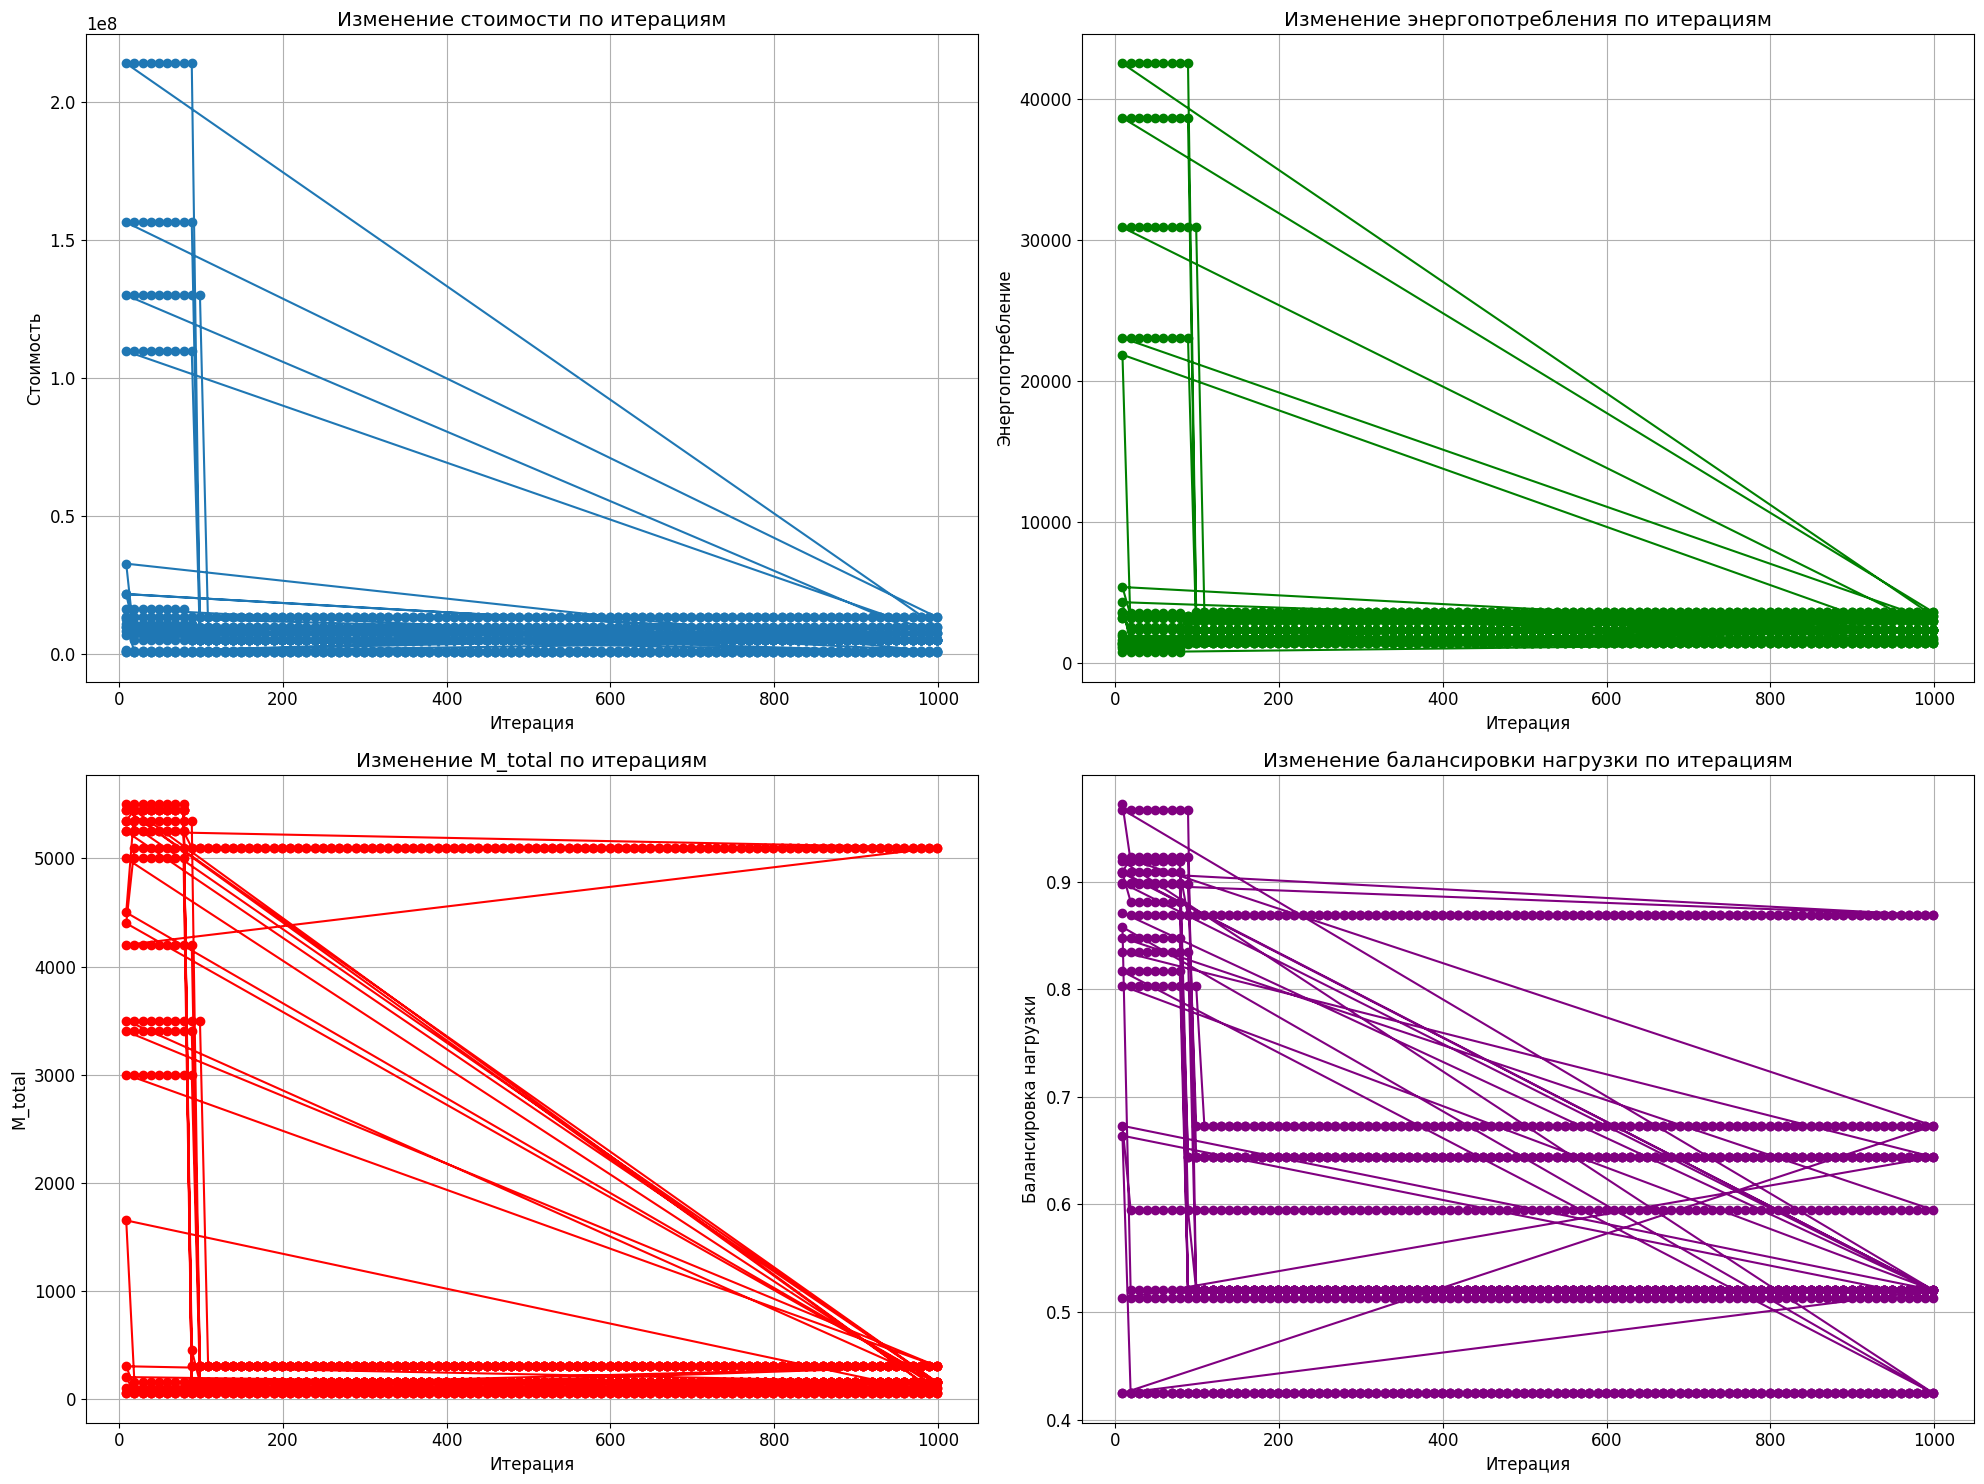

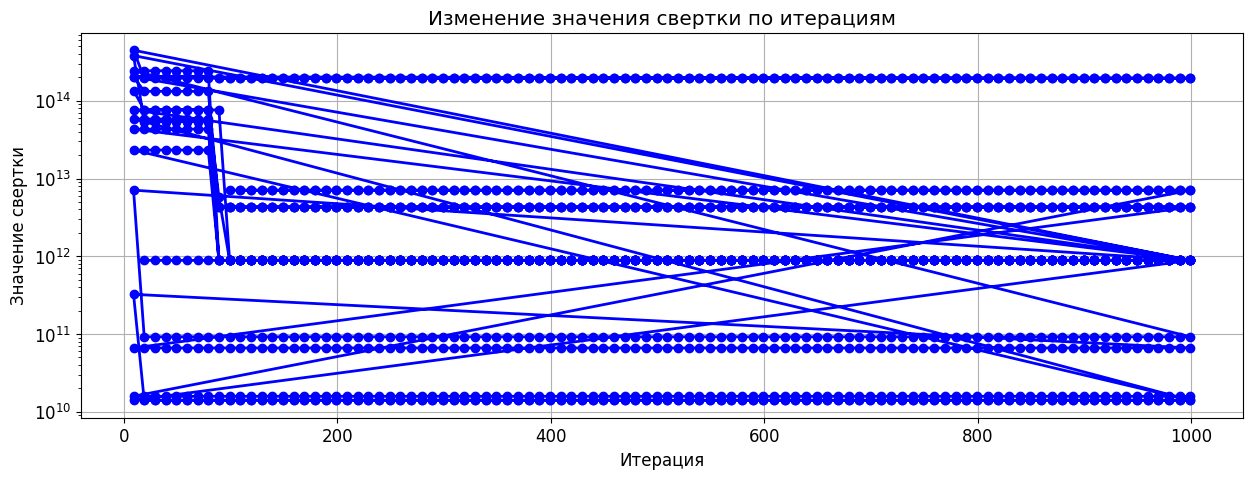

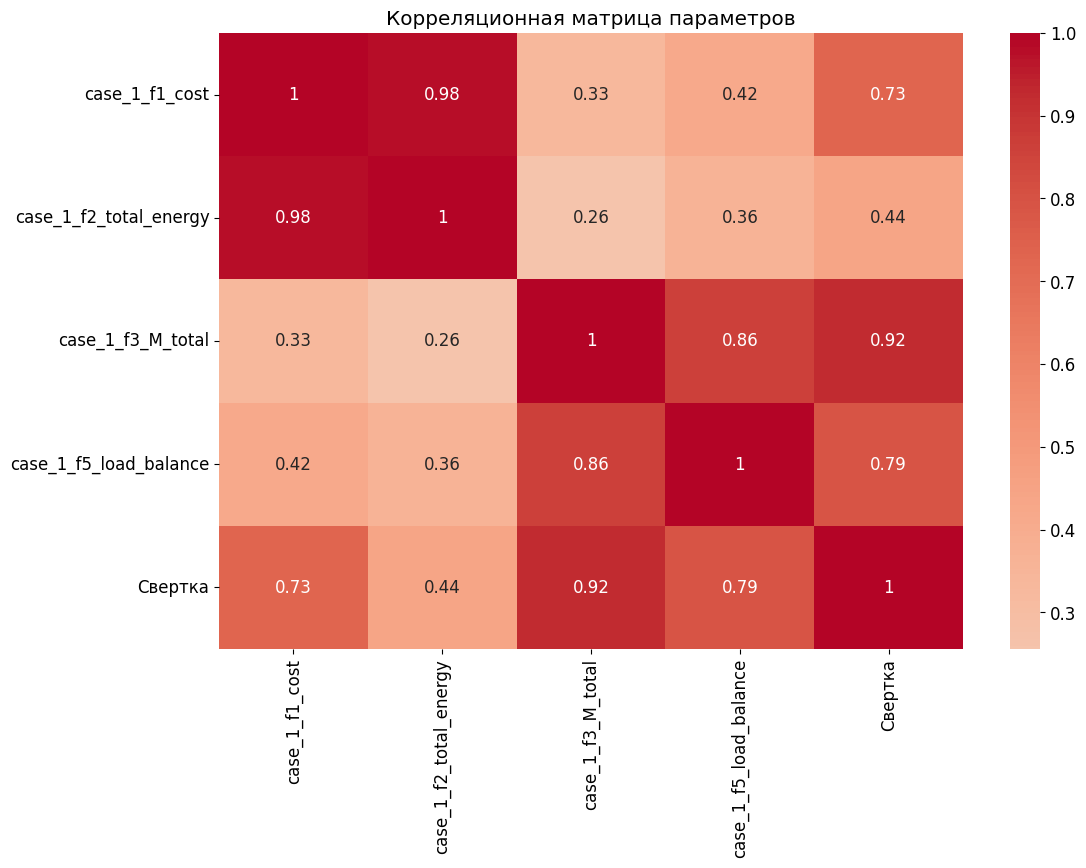

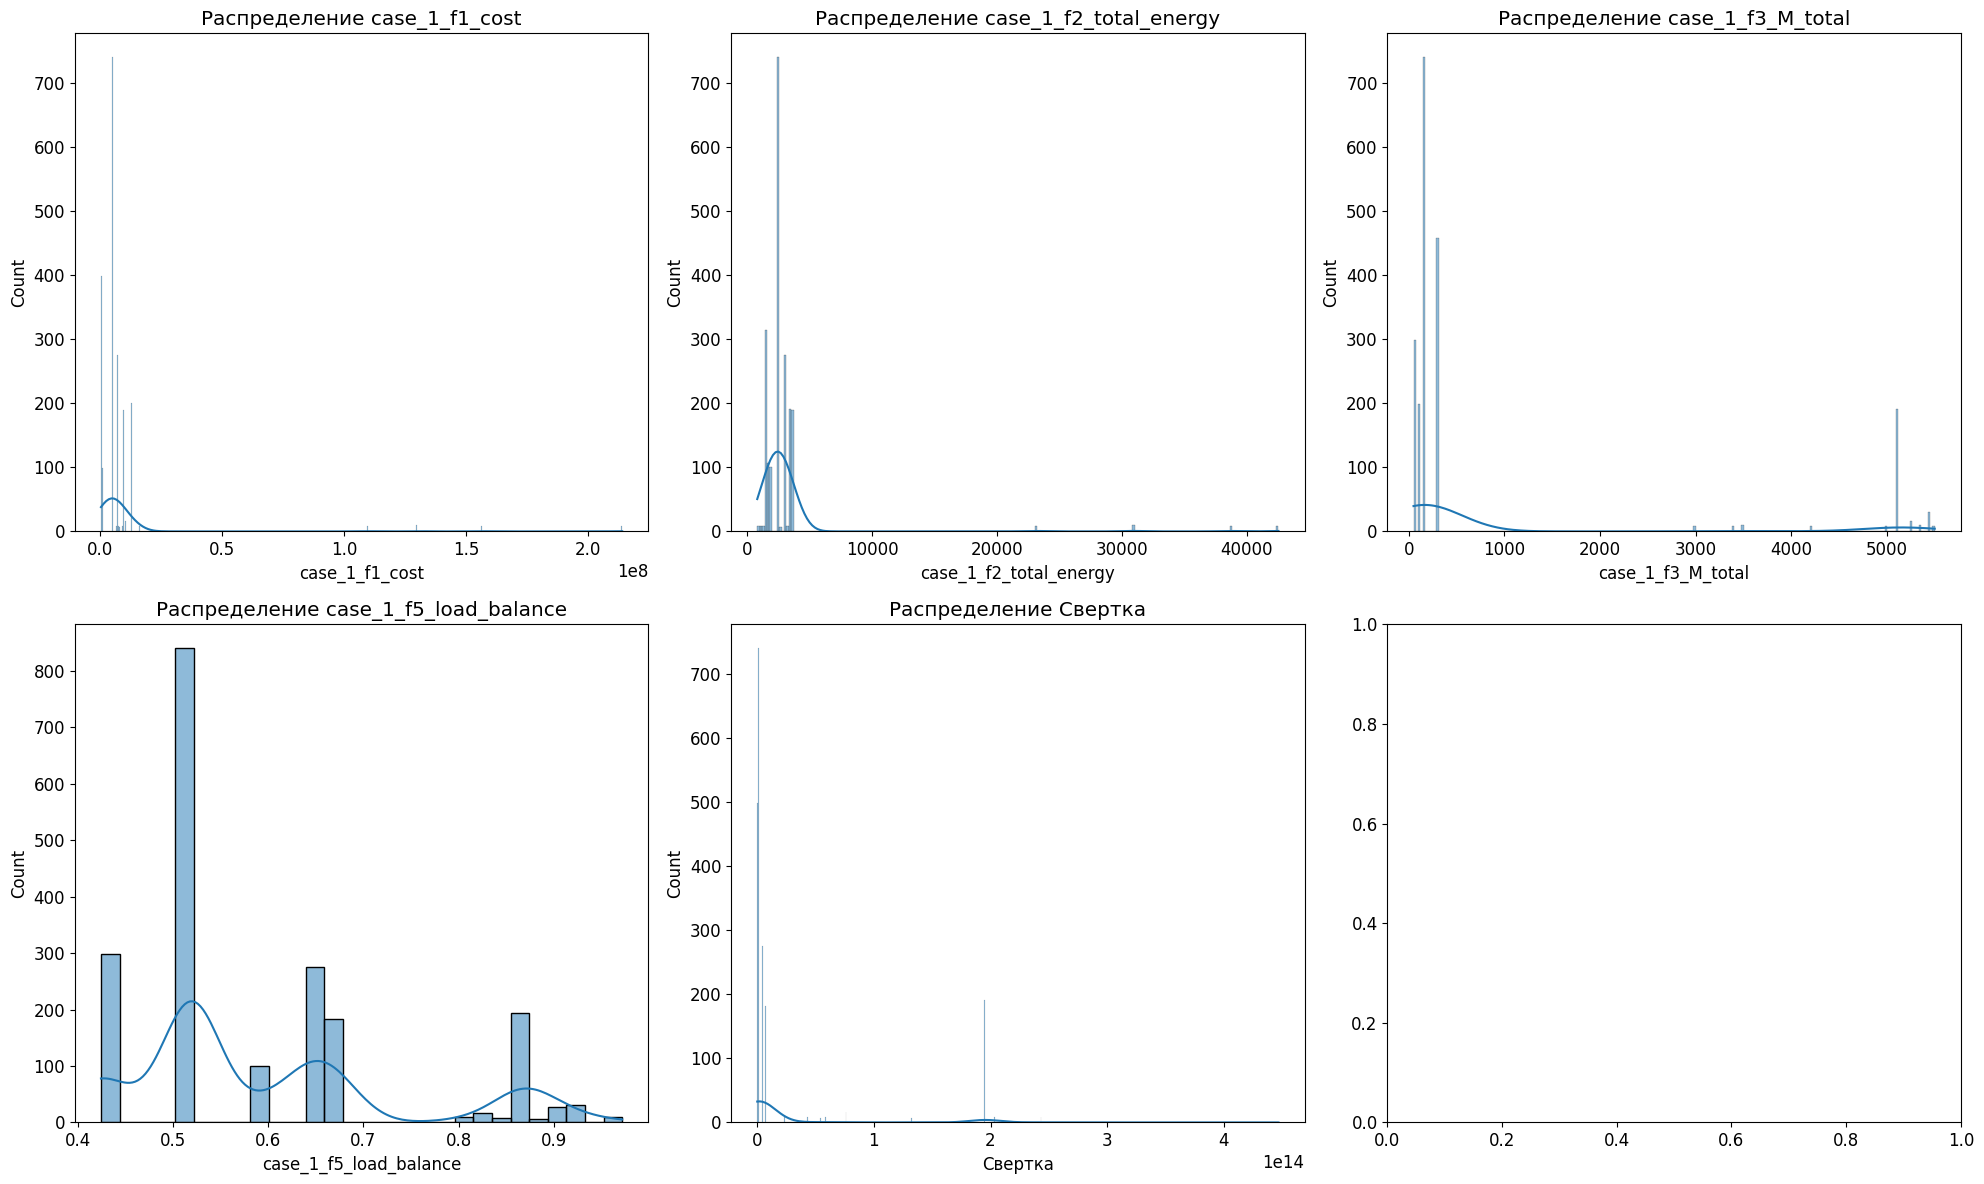

c:\Users\meon4\Documents\MATH\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Импорт данных из Excel
df = pd.read_excel(r'C:\Users\meon4\Documents\MATH\Новые расчеты\data\CASE1PSO.xlsx')

# Настройка стиля графиков
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 12

# Создаем figure с подграфиками
fig = plt.figure(figsize=(20, 15))

# 1. График изменения стоимости (f1_cost)
plt.subplot(2, 2, 1)
plt.plot(df['iteration'], df['case_1_f1_cost'], marker='o')
plt.title('Изменение стоимости по итерациям')
plt.xlabel('Итерация')
plt.ylabel('Стоимость')
plt.grid(True)

# 2. График изменения энергии (f2_energy)
plt.subplot(2, 2, 2)
plt.plot(df['iteration'], df['case_1_f2_total_energy'], marker='o', color='green')
plt.title('Изменение энергопотребления по итерациям')
plt.xlabel('Итерация')
plt.ylabel('Энергопотребление')
plt.grid(True)

# 3. График изменения M_total
plt.subplot(2, 2, 3)
plt.plot(df['iteration'], df['case_1_f3_M_total'], marker='o', color='red')
plt.title('Изменение M_total по итерациям')
plt.xlabel('Итерация')
plt.ylabel('M_total')
plt.grid(True)

# 4. График изменения балансировки нагрузки
plt.subplot(2, 2, 4)
plt.plot(df['iteration'], df['case_1_f5_load_balance'], marker='o', color='purple')
plt.title('Изменение балансировки нагрузки по итерациям')
plt.xlabel('Итерация')
plt.ylabel('Балансировка нагрузки')
plt.grid(True)

plt.tight_layout()

# Создаем второй график для свертки
plt.figure(figsize=(15, 5))
plt.plot(df['iteration'], df['Свертка'], marker='o', color='blue', linewidth=2)
plt.title('Изменение значения свертки по итерациям')
plt.xlabel('Итерация')
plt.ylabel('Значение свертки')
plt.grid(True)
plt.yscale('log')  # Логарифмический масштаб для большой разницы значений

# Статистический анализ
print("\nСтатистический анализ:")
print("\nОсновные статистики:")
stats_columns = ['case_1_f1_cost', 'case_1_f2_total_energy', 
                 'case_1_f3_M_total', 'case_1_f5_load_balance', 'Свертка']
print(df[stats_columns].describe())

# Анализ корреляций
correlation_matrix = df[stats_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Корреляционная матрица параметров')

# Анализ распределения значений
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()

for idx, col in enumerate(stats_columns):
    if idx < len(axes):
        sns.histplot(data=df, x=col, kde=True, ax=axes[idx])
        axes[idx].set_title(f'Распределение {col}')

plt.tight_layout()

# Дополнительный анализ векторов решений
print("\nАнализ уникальных векторов решений:")
unique_vectors = df['vector'].unique()
print(f"Количество уникальных векторов: {len(unique_vectors)}")
print("\nУникальные векторы:")
for vec in unique_vectors:
    print(vec)

# Основные выводы
print("\nОсновные выводы:")
print(f"1. Наблюдается стабилизация решения после итерации {df[df['case_1_f1_cost'] == df['case_1_f1_cost'].min()]['iteration'].iloc[0]}")
print(f"2. Минимальная стоимость: {df['case_1_f1_cost'].min():.2f}")
print(f"3. Максимальная балансировка нагрузки: {df['case_1_f5_load_balance'].max():.4f}")
print(f"4. Оптимальное значение свертки: {df['Свертка'].min():.2e}")

# Показываем все графики
plt.show()

# Сохранение результатов анализа в Excel
with pd.ExcelWriter('analysis_results.xlsx') as writer:
    df.describe().to_excel(writer, sheet_name='Statistics')
    correlation_matrix.to_excel(writer, sheet_name='Correlations')
    pd.DataFrame({'Unique_Vectors': unique_vectors}).to_excel(writer, sheet_name='Unique_Vectors')



Статистический анализ конечных результатов:
       case_1_f1_cost  case_1_f2_total_energy  case_1_f3_M_total  \
count    2.000000e+01               20.000000           20.00000   
mean     5.477307e+06             2479.265092          662.50000   
std      3.873962e+06              705.183364         1520.03073   
min      4.560519e+05             1432.867109           50.00000   
25%      3.849548e+06             2205.899773          137.50000   
50%      4.844385e+06             2344.316478          150.00000   
75%      7.352825e+06             3022.777603          300.00000   
max      1.313614e+07             3619.010187         5100.00000   

       case_1_f5_load_balance       Свертка  
count               20.000000  2.000000e+01  
mean                 0.577929  2.122648e+13  
std                  0.126101  5.950305e+13  
min                  0.424437  1.409273e+10  
25%                  0.520272  6.877533e+11  
50%                  0.520272  8.862909e+11  
75%                 

c:\Users\meon4\Documents\MATH\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


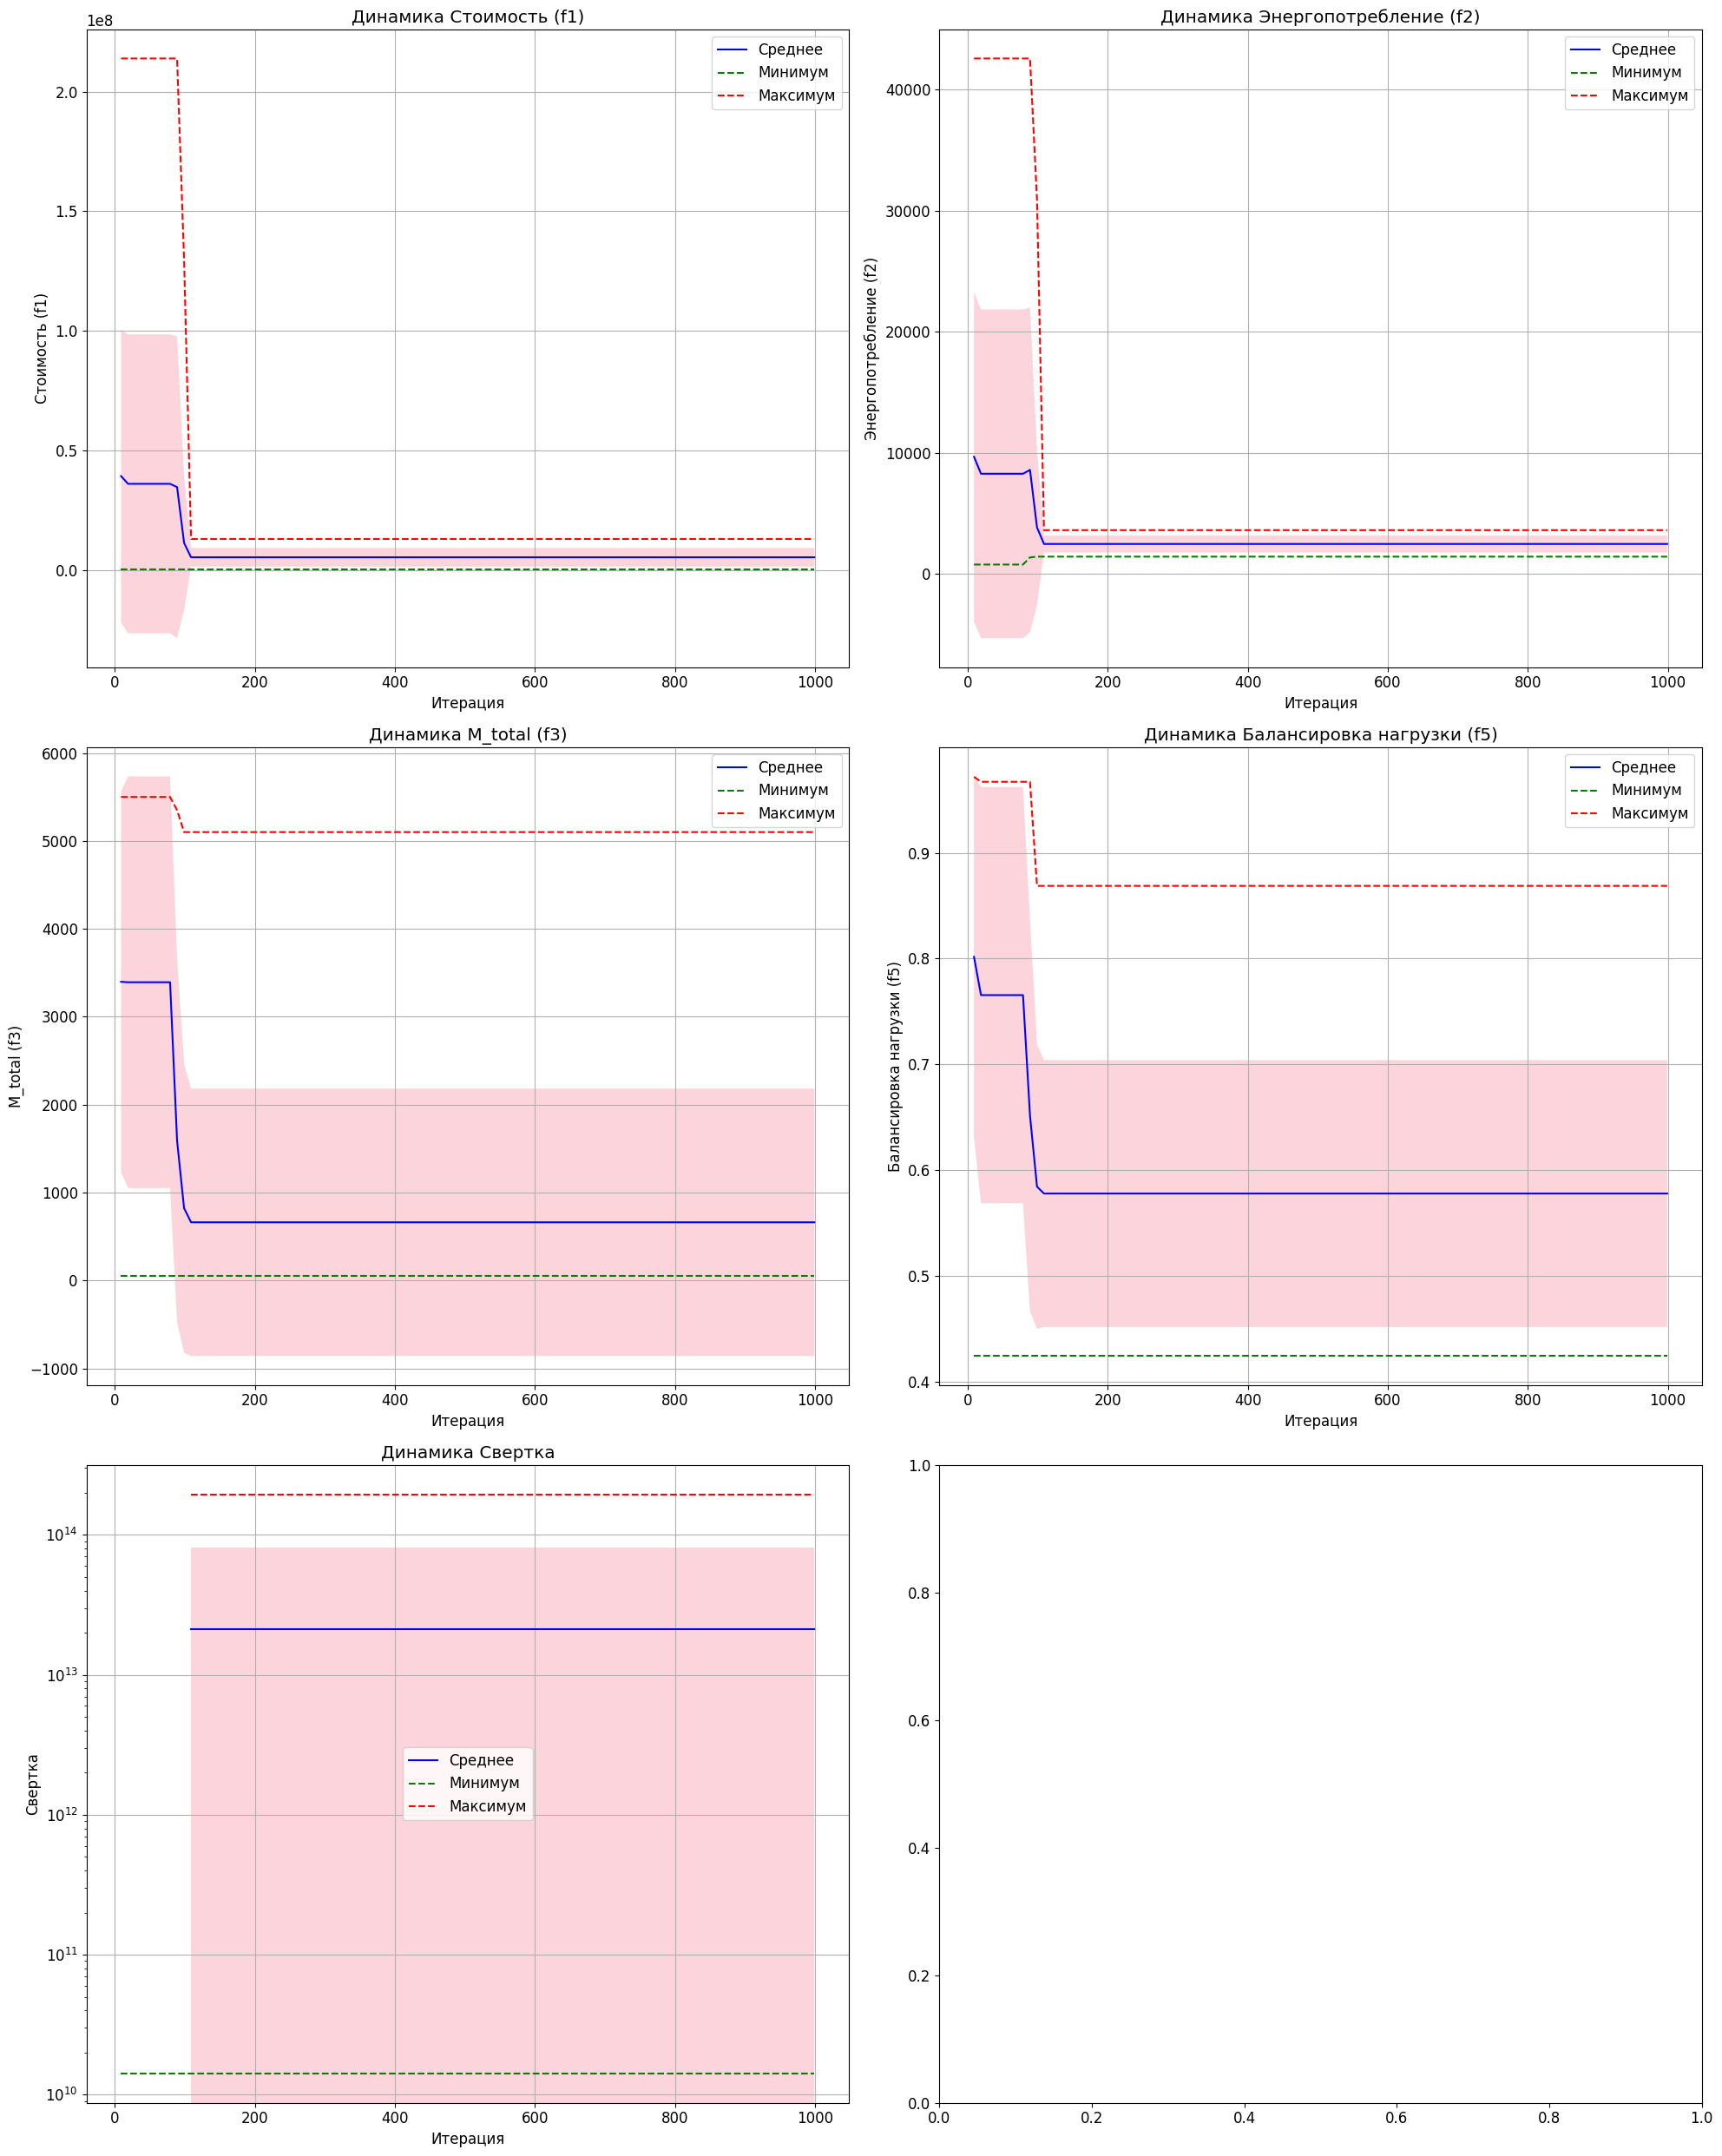

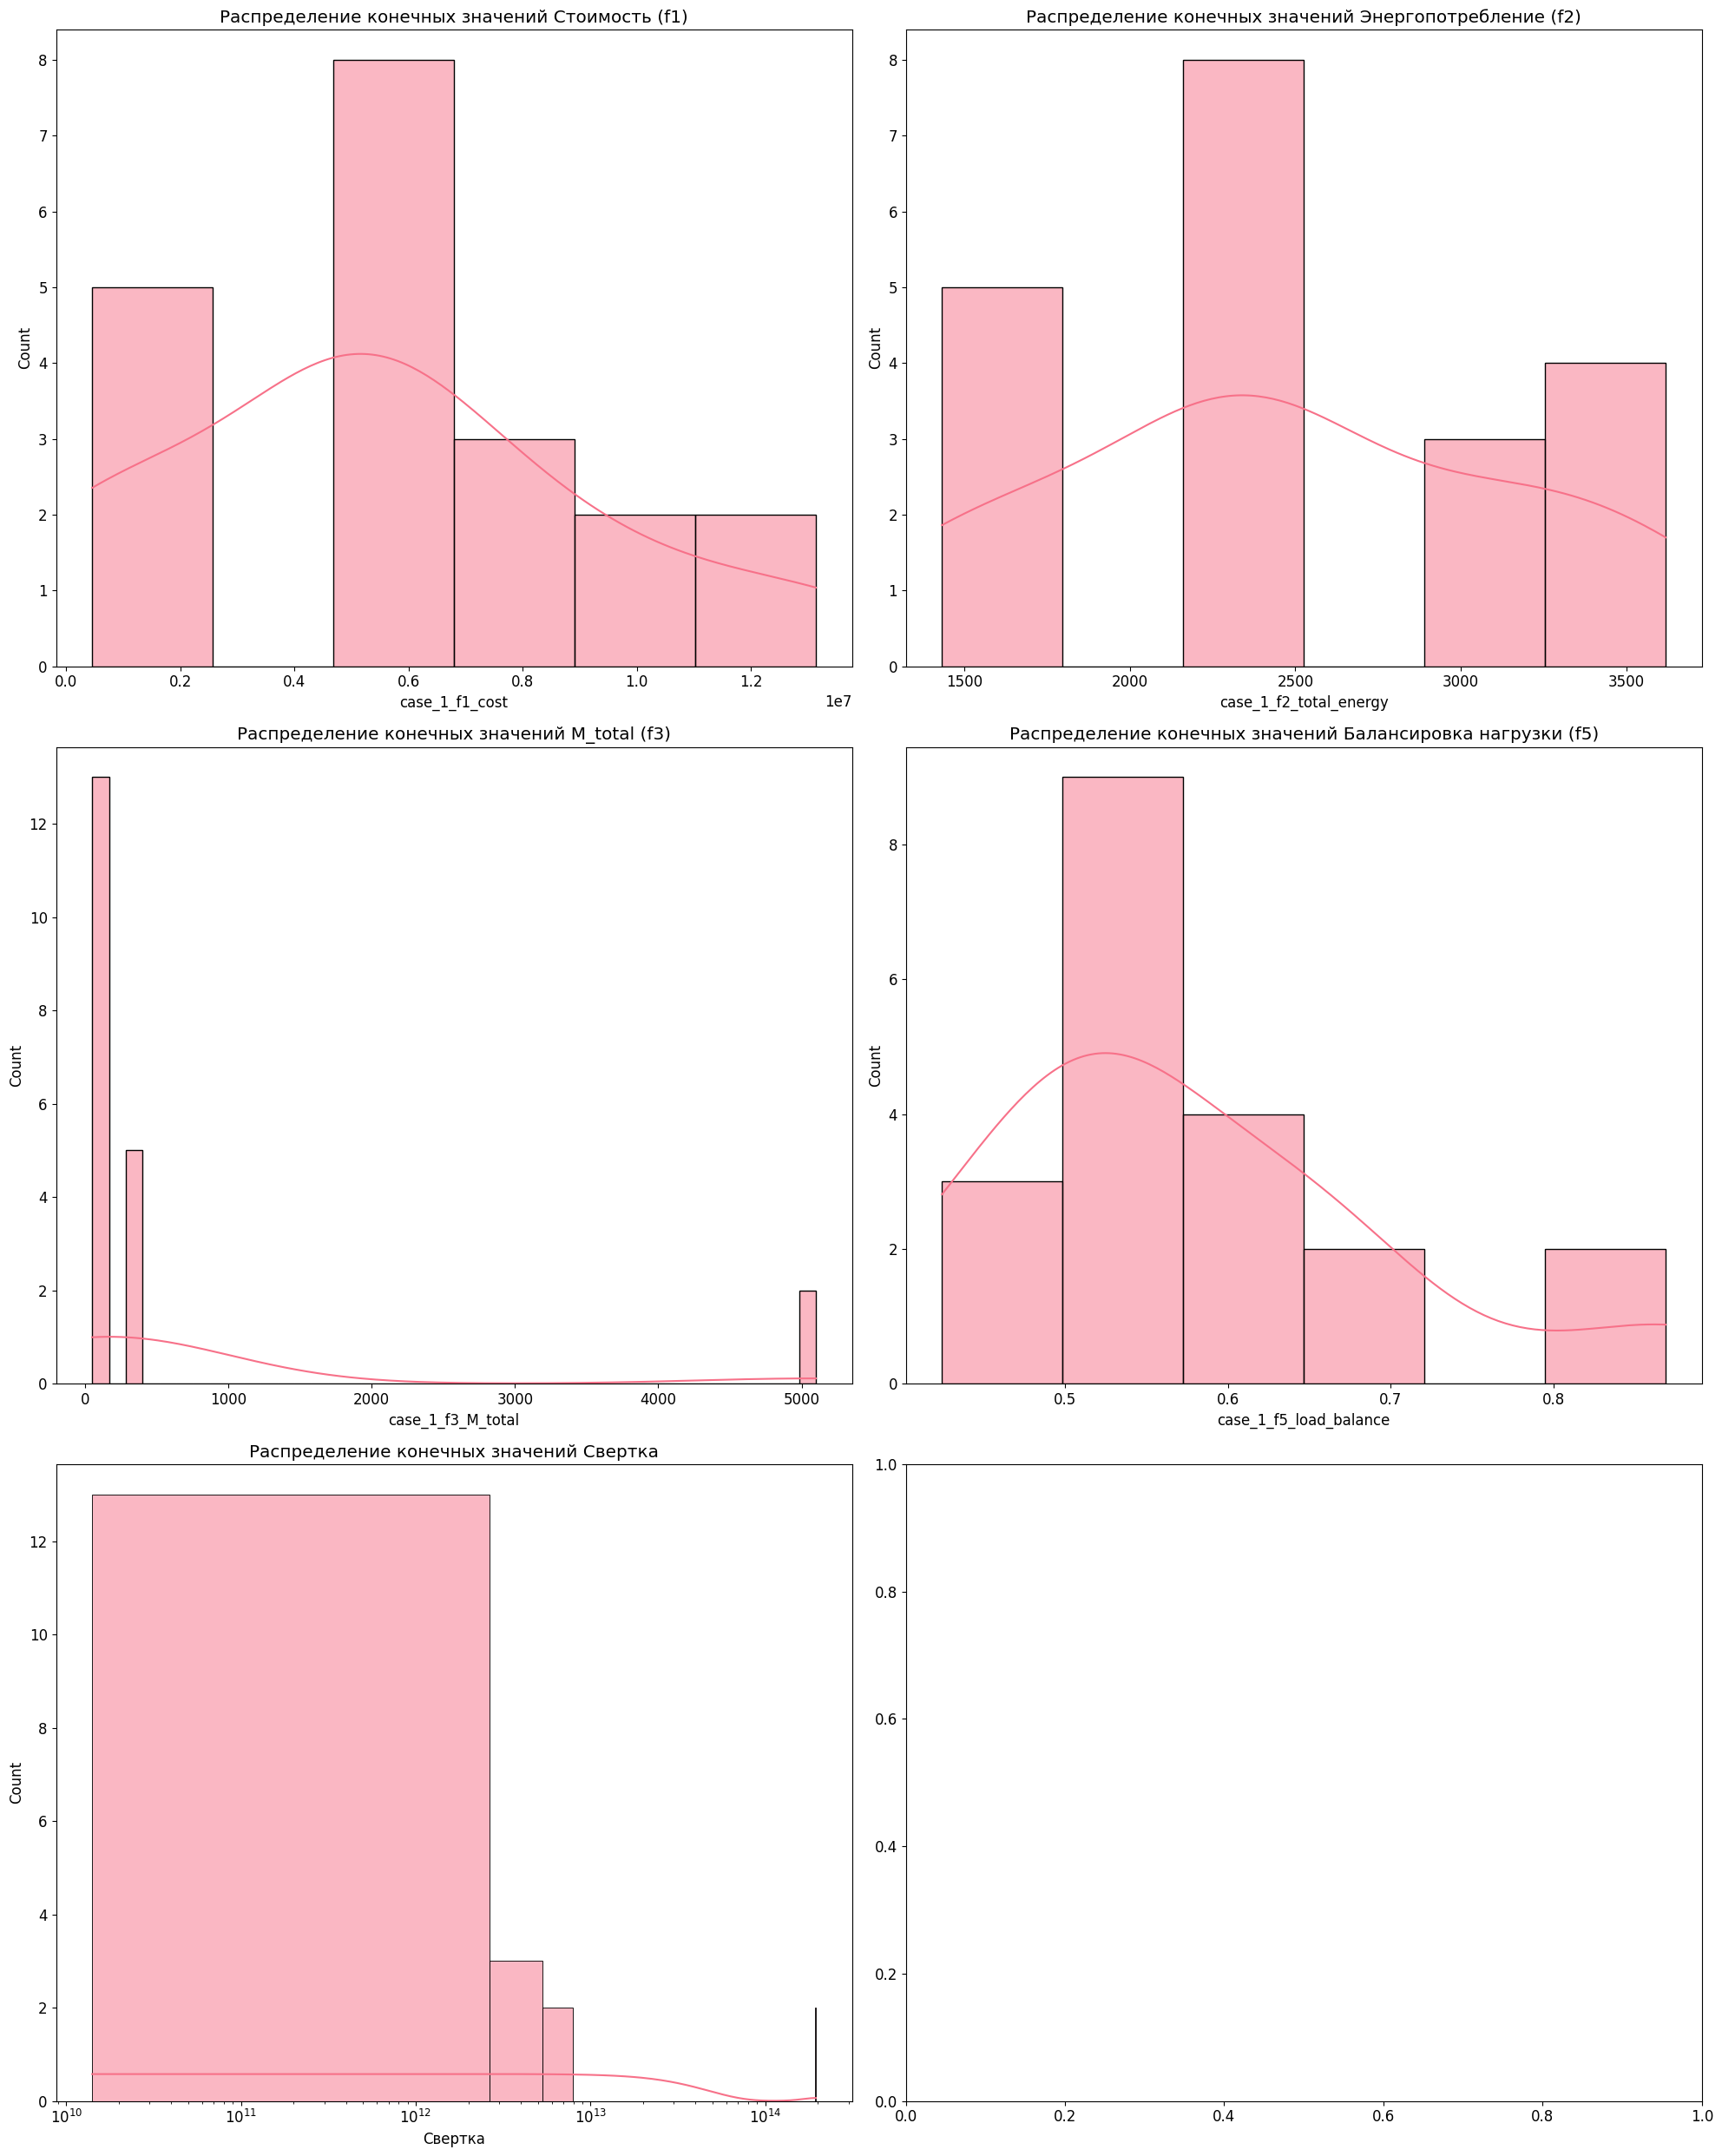

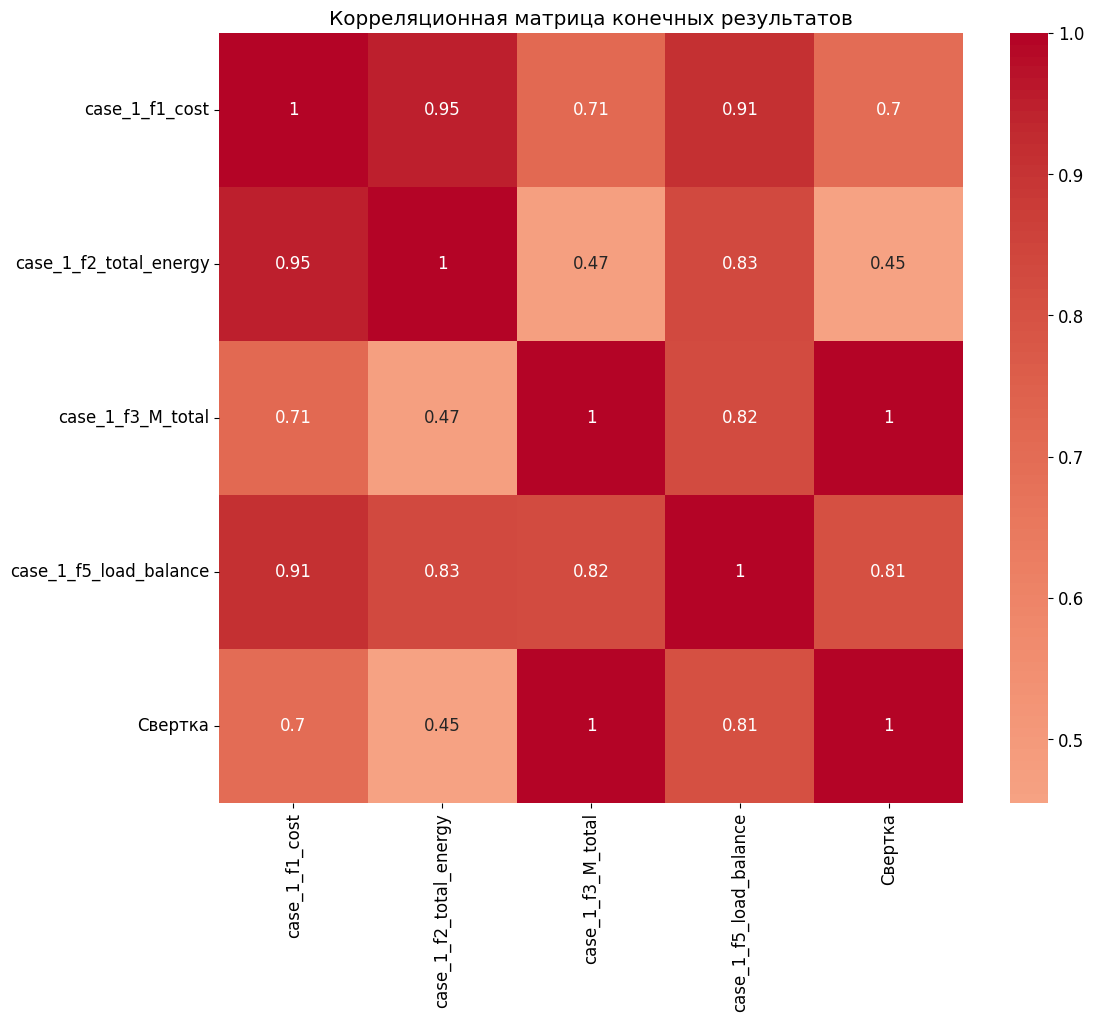


Основные выводы:
1. Общее количество экспериментов: 20
2. Лучшее значение свертки: 1.41e+10
3. Медианное значение свертки: 8.86e+11
4. Количество уникальных векторов решений: 8
5. Стабильность решения (доля одинаковых векторов): 40.00%


In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Импорт данных
df = pd.read_excel(r'C:\Users\meon4\Documents\MATH\Новые расчеты\data\CASE1PSO.xlsx')

# Настройка стиля
sns.set_palette("husl")

# 1. Анализ сходимости по всем экспериментам
metrics = {
    'case_1_f1_cost': 'Стоимость (f1)',
    'case_1_f2_total_energy': 'Энергопотребление (f2)',
    'case_1_f3_M_total': 'M_total (f3)',
    'case_1_f5_load_balance': 'Балансировка нагрузки (f5)',
    'Свертка': 'Свертка'
}

# Создаем агрегированные графики
fig, axes = plt.subplots(3, 2, figsize=(20, 25))
axes = axes.ravel()

for idx, (metric, title) in enumerate(metrics.items()):
    # Вычисляем статистики по итерациям
    stats_df = df.groupby('iteration')[metric].agg(['mean', 'std', 'min', 'max']).reset_index()
    
    axes[idx].fill_between(stats_df['iteration'], 
                          stats_df['mean'] - stats_df['std'],
                          stats_df['mean'] + stats_df['std'],
                          alpha=0.3)
    axes[idx].plot(stats_df['iteration'], stats_df['mean'], 'b-', label='Среднее')
    axes[idx].plot(stats_df['iteration'], stats_df['min'], 'g--', label='Минимум')
    axes[idx].plot(stats_df['iteration'], stats_df['max'], 'r--', label='Максимум')
    
    axes[idx].set_title(f'Динамика {title}')
    axes[idx].set_xlabel('Итерация')
    axes[idx].set_ylabel(title)
    axes[idx].grid(True)
    axes[idx].legend()
    
    if metric == 'Свертка':
        axes[idx].set_yscale('log')

plt.tight_layout()

# 2. Статистический анализ конечных результатов
final_results = df.groupby('Эксперимент').last().reset_index()

print("\nСтатистический анализ конечных результатов:")
stats_summary = final_results[list(metrics.keys())].describe()
print(stats_summary)

# 3. Анализ распределения конечных результатов
fig, axes = plt.subplots(3, 2, figsize=(20, 25))
axes = axes.ravel()

for idx, (metric, title) in enumerate(metrics.items()):
    sns.histplot(data=final_results, x=metric, kde=True, ax=axes[idx])
    axes[idx].set_title(f'Распределение конечных значений {title}')
    if metric == 'Свертка':
        axes[idx].set_xscale('log')

plt.tight_layout()

# 4. Анализ корреляций конечных результатов
plt.figure(figsize=(12, 10))
correlation_matrix = final_results[list(metrics.keys())].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Корреляционная матрица конечных результатов')

# 5. Анализ лучших решений
print("\nАнализ лучших решений:")
best_solutions = final_results.nsmallest(10, 'Свертка')
print("\nТоп-10 лучших решений:")
print(best_solutions[['Эксперимент', 'vector'] + list(metrics.keys())])

# 6. Анализ векторов решений
vectors = final_results['vector'].value_counts()
print("\nЧастота встречаемости различных векторов решений:")
print(vectors.head(10))

# 7. Статистика сходимости
convergence_stats = pd.DataFrame()
for metric in metrics.keys():
    best_value = df[metric].min() if metric != 'case_1_f5_load_balance' else df[metric].max()
    distances = abs(df[metric] - best_value) / abs(best_value) * 100
    convergence_stats[f'{metric}_rel_error'] = distances.describe()

print("\nСтатистика сходимости (относительная ошибка в %):")
print(convergence_stats)

# 8. Сохранение результатов
with pd.ExcelWriter('comprehensive_analysis_results.xlsx') as writer:
    stats_summary.to_excel(writer, sheet_name='Final_Statistics')
    correlation_matrix.to_excel(writer, sheet_name='Correlations')
    best_solutions.to_excel(writer, sheet_name='Top10_Solutions')
    vectors.head(20).to_excel(writer, sheet_name='Vector_Frequencies')
    convergence_stats.to_excel(writer, sheet_name='Convergence_Stats')

# 9. Критерии эффективности
print("\nКритерии эффективности алгоритма:")
success_rate = len(best_solutions[best_solutions['Свертка'] <= best_solutions['Свертка'].mean()]) / len(final_results) * 100
print(f"Процент успешных решений: {success_rate:.2f}%")

# Среднее количество итераций до сходимости
convergence_threshold = 0.01  # 1% от лучшего значения
for metric in metrics.keys():
    best_value = df[metric].min() if metric != 'case_1_f5_load_balance' else df[metric].max()
    convergence_iterations = []
    
    for exp in df['Эксперимент'].unique():
        exp_data = df[df['Эксперимент'] == exp]
        relative_error = abs(exp_data[metric] - best_value) / abs(best_value)
        converged_iterations = exp_data[relative_error <= convergence_threshold]['iteration']
        if not converged_iterations.empty:
            convergence_iterations.append(converged_iterations.iloc[0])
    
    if convergence_iterations:
        avg_convergence = np.mean(convergence_iterations)
        print(f"Среднее количество итераций до сходимости для {metrics[metric]}: {avg_convergence:.2f}")

plt.show()

# 10. Дополнительные выводы
print("\nОсновные выводы:")
print(f"1. Общее количество экспериментов: {len(df['Эксперимент'].unique())}")
print(f"2. Лучшее значение свертки: {final_results['Свертка'].min():.2e}")
print(f"3. Медианное значение свертки: {final_results['Свертка'].median():.2e}")
print(f"4. Количество уникальных векторов решений: {len(vectors)}")
print(f"5. Стабильность решения (доля одинаковых векторов): {(vectors.iloc[0]/len(final_results))*100:.2f}%")



Статистический анализ конечных результатов:
       case_1_f1_cost_norm  case_1_f2_total_energy_norm  \
count            20.000000                    20.000000   
mean              0.402639                     0.558550   
std               0.244712                     0.042506   
min               0.037447                     0.481264   
25%               0.315352                     0.543204   
50%               0.401486                     0.562976   
75%               0.533831                     0.562976   
max               0.796215                     0.633999   

       case_1_f3_M_total_norm  case_1_f5_load_balance_norm    Свертка  
count               20.000000                    20.000000  20.000000  
mean                 0.120721                     0.584116   0.034986  
std                  0.273466                     0.126159   0.092746  
min                  0.009009                     0.424437   0.000091  
25%                  0.024775                     0.520272   0.

c:\Users\meon4\Documents\MATH\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


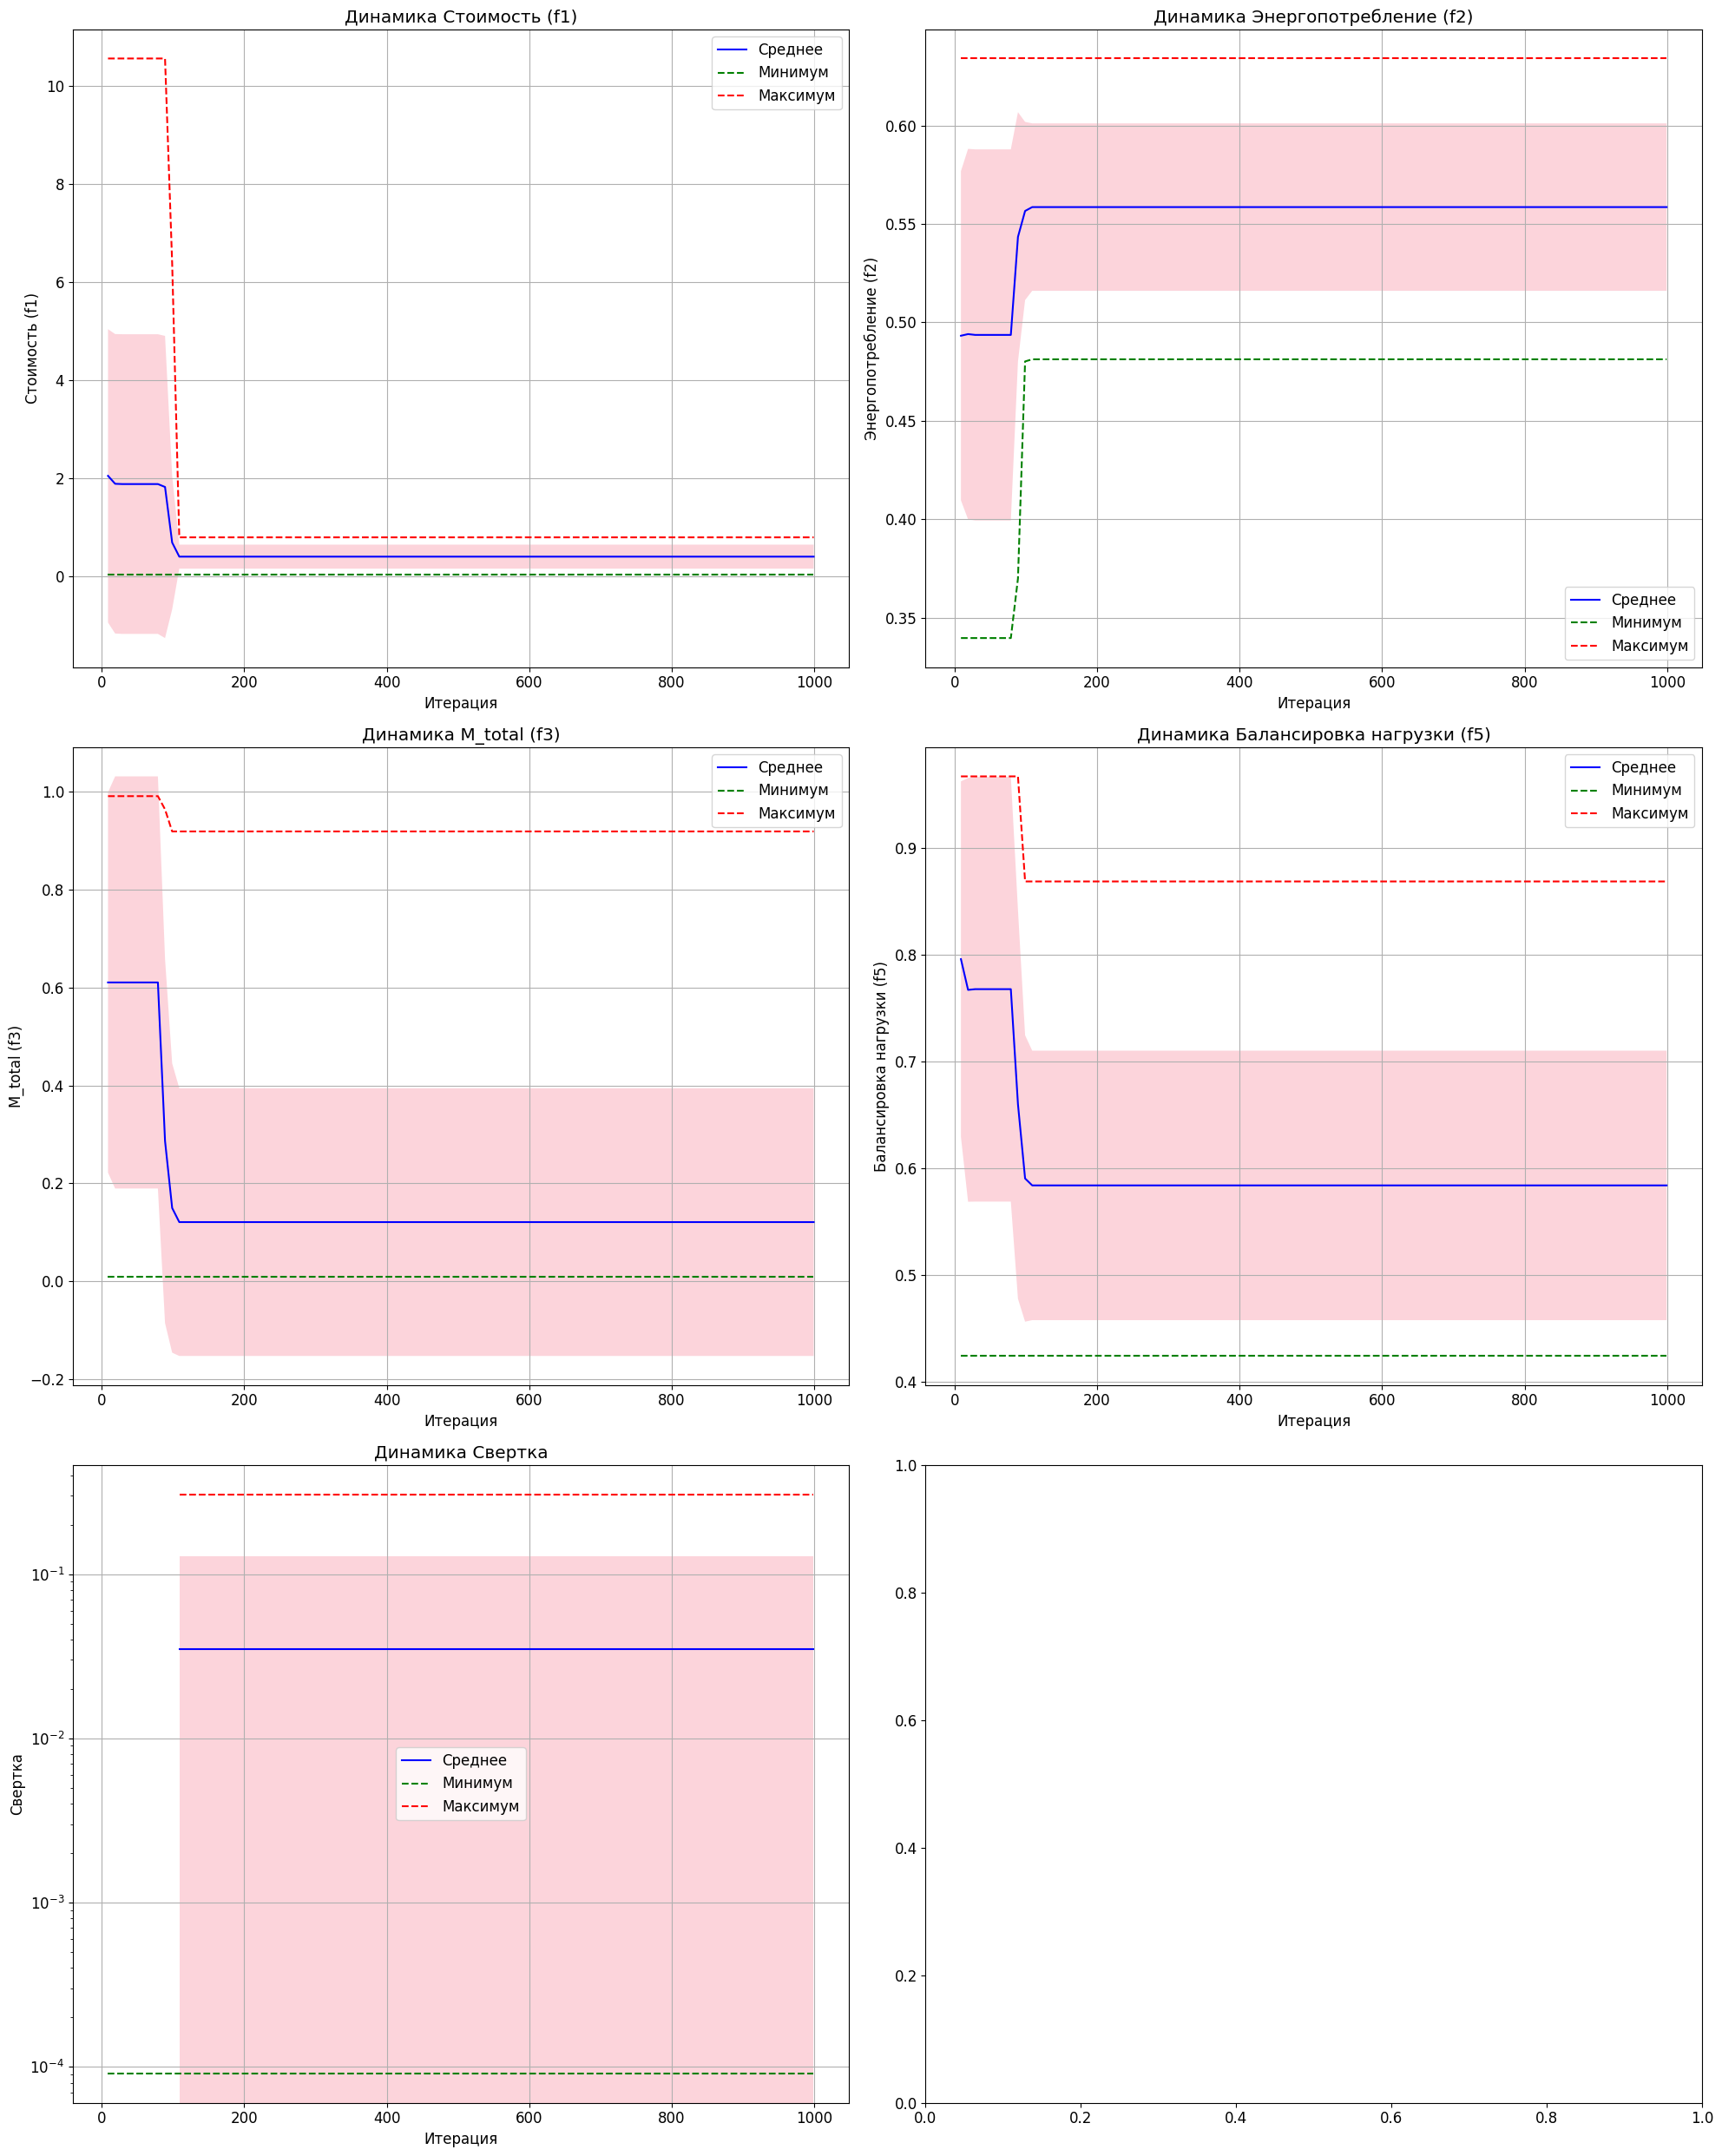

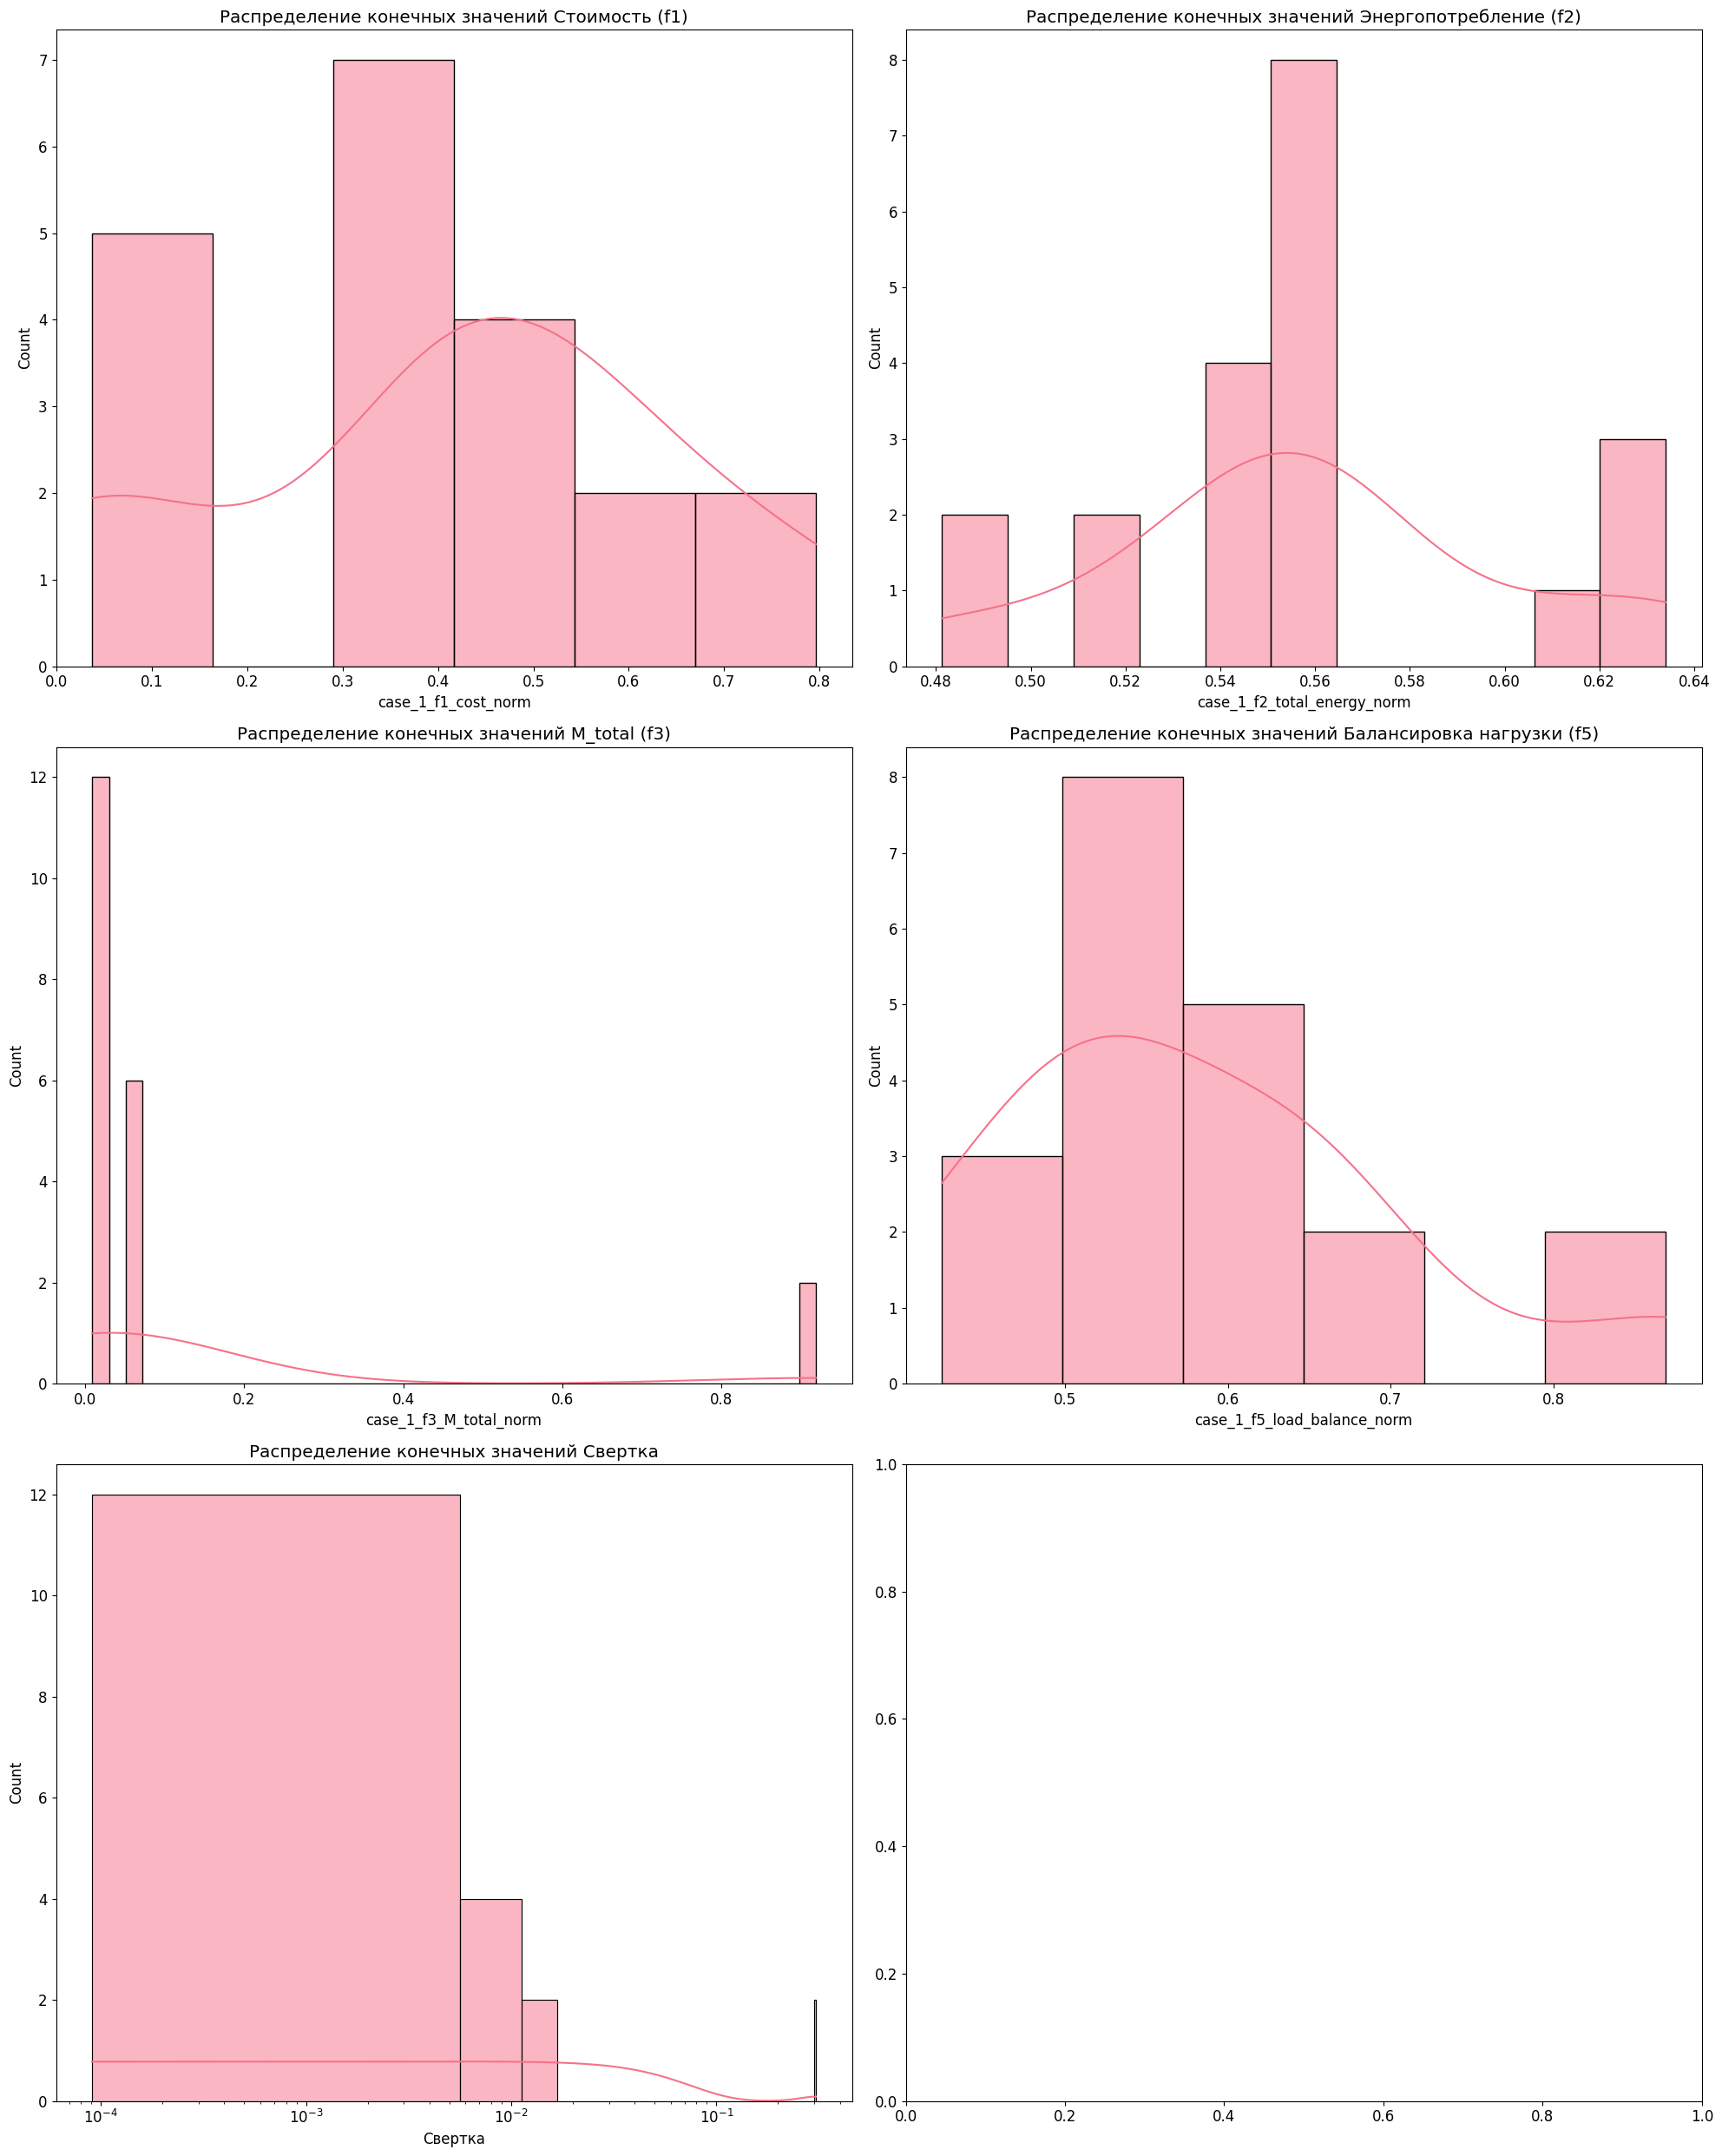

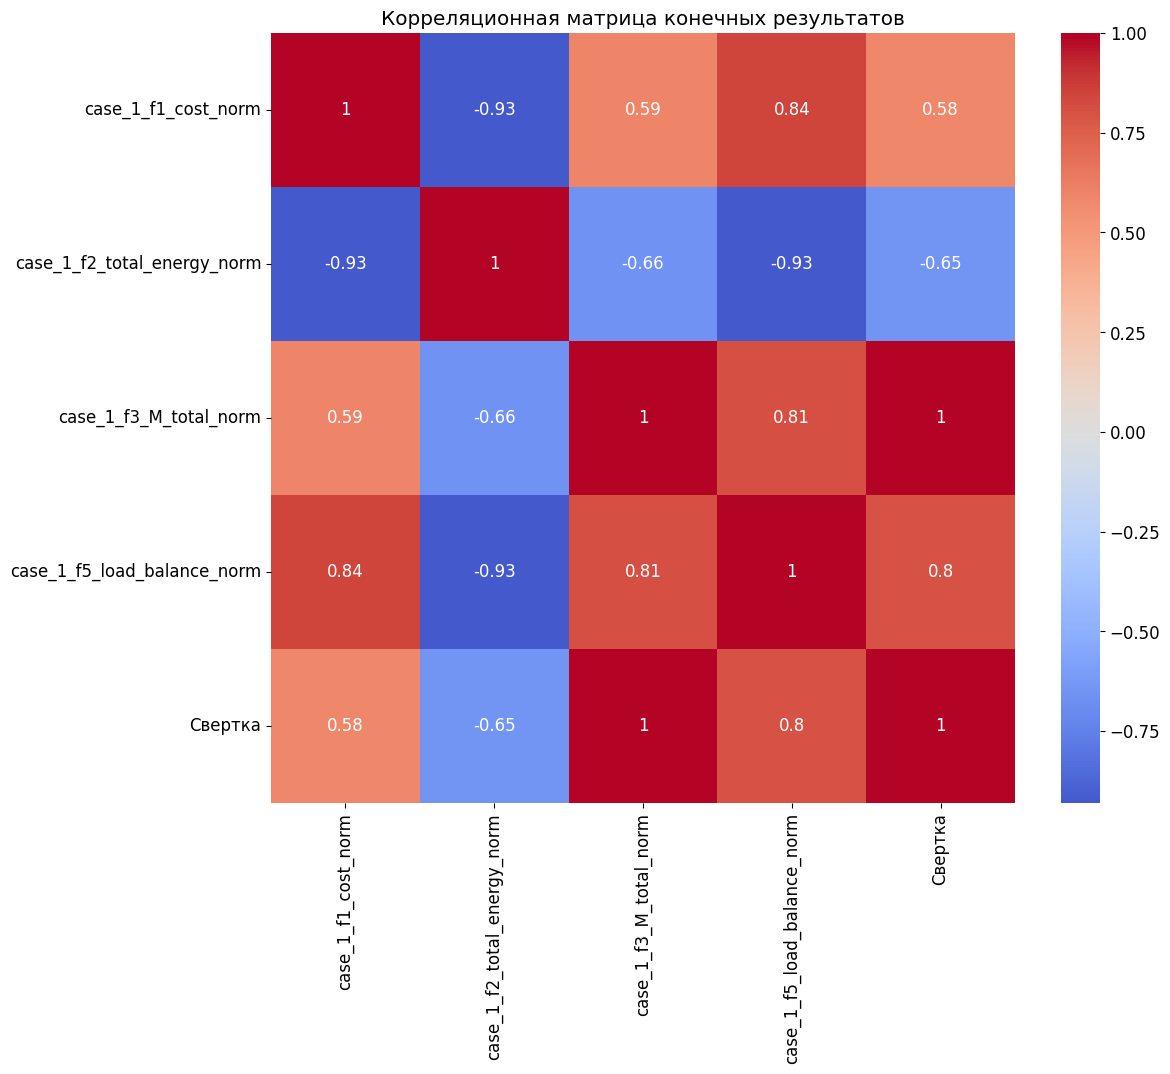


Основные выводы:
1. Общее количество экспериментов: 20
2. Лучшее значение свертки: 9.08e-05
3. Медианное значение свертки: 3.18e-03
4. Количество уникальных векторов решений: 8
5. Стабильность решения (доля одинаковых векторов): 35.00%


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Импорт данных
df = pd.read_excel(r'C:\Users\meon4\Documents\MATH\Новые расчеты\data\CASE1_normPSO.xlsx')

# Настройка стиля
sns.set_palette("husl")

# 1. Анализ сходимости по всем экспериментам
metrics = {
    'case_1_f1_cost_norm': 'Стоимость (f1)',
    'case_1_f2_total_energy_norm': 'Энергопотребление (f2)',
    'case_1_f3_M_total_norm': 'M_total (f3)',
    'case_1_f5_load_balance_norm': 'Балансировка нагрузки (f5)',
    'Свертка': 'Свертка'
}

# Создаем агрегированные графики
fig, axes = plt.subplots(3, 2, figsize=(20, 25))
axes = axes.ravel()

for idx, (metric, title) in enumerate(metrics.items()):
    # Вычисляем статистики по итерациям
    stats_df = df.groupby('iteration')[metric].agg(['mean', 'std', 'min', 'max']).reset_index()
    
    axes[idx].fill_between(stats_df['iteration'], 
                          stats_df['mean'] - stats_df['std'],
                          stats_df['mean'] + stats_df['std'],
                          alpha=0.3)
    axes[idx].plot(stats_df['iteration'], stats_df['mean'], 'b-', label='Среднее')
    axes[idx].plot(stats_df['iteration'], stats_df['min'], 'g--', label='Минимум')
    axes[idx].plot(stats_df['iteration'], stats_df['max'], 'r--', label='Максимум')
    
    axes[idx].set_title(f'Динамика {title}')
    axes[idx].set_xlabel('Итерация')
    axes[idx].set_ylabel(title)
    axes[idx].grid(True)
    axes[idx].legend()
    
    if metric == 'Свертка':
        axes[idx].set_yscale('log')

plt.tight_layout()

# 2. Статистический анализ конечных результатов
final_results = df.groupby('Эксперимент').last().reset_index()

print("\nСтатистический анализ конечных результатов:")
stats_summary = final_results[list(metrics.keys())].describe()
print(stats_summary)

# 3. Анализ распределения конечных результатов
fig, axes = plt.subplots(3, 2, figsize=(20, 25))
axes = axes.ravel()

for idx, (metric, title) in enumerate(metrics.items()):
    sns.histplot(data=final_results, x=metric, kde=True, ax=axes[idx])
    axes[idx].set_title(f'Распределение конечных значений {title}')
    if metric == 'Свертка':
        axes[idx].set_xscale('log')

plt.tight_layout()

# 4. Анализ корреляций конечных результатов
plt.figure(figsize=(12, 10))
correlation_matrix = final_results[list(metrics.keys())].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Корреляционная матрица конечных результатов')

# 5. Анализ лучших решений
print("\nАнализ лучших решений:")
best_solutions = final_results.nsmallest(10, 'Свертка')
print("\nТоп-10 лучших решений:")
print(best_solutions[['Эксперимент', 'vector'] + list(metrics.keys())])

# 6. Анализ векторов решений
vectors = final_results['vector'].value_counts()
print("\nЧастота встречаемости различных векторов решений:")
print(vectors.head(10))

# 7. Статистика сходимости
convergence_stats = pd.DataFrame()
for metric in metrics.keys():
    best_value = df[metric].min() if metric != 'case_1_f5_load_balance' else df[metric].max()
    distances = abs(df[metric] - best_value) / abs(best_value) * 100
    convergence_stats[f'{metric}_rel_error'] = distances.describe()

print("\nСтатистика сходимости (относительная ошибка в %):")
print(convergence_stats)

# 8. Сохранение результатов
with pd.ExcelWriter('comprehensive_analysis_results.xlsx') as writer:
    stats_summary.to_excel(writer, sheet_name='Final_Statistics')
    correlation_matrix.to_excel(writer, sheet_name='Correlations')
    best_solutions.to_excel(writer, sheet_name='Top10_Solutions')
    vectors.head(20).to_excel(writer, sheet_name='Vector_Frequencies')
    convergence_stats.to_excel(writer, sheet_name='Convergence_Stats')

# 9. Критерии эффективности
print("\nКритерии эффективности алгоритма:")
success_rate = len(best_solutions[best_solutions['Свертка'] <= best_solutions['Свертка'].mean()]) / len(final_results) * 100
print(f"Процент успешных решений: {success_rate:.2f}%")

# Среднее количество итераций до сходимости
convergence_threshold = 0.01  # 1% от лучшего значения
for metric in metrics.keys():
    best_value = df[metric].min() if metric != 'case_1_f5_load_balance' else df[metric].max()
    convergence_iterations = []
    
    for exp in df['Эксперимент'].unique():
        exp_data = df[df['Эксперимент'] == exp]
        relative_error = abs(exp_data[metric] - best_value) / abs(best_value)
        converged_iterations = exp_data[relative_error <= convergence_threshold]['iteration']
        if not converged_iterations.empty:
            convergence_iterations.append(converged_iterations.iloc[0])
    
    if convergence_iterations:
        avg_convergence = np.mean(convergence_iterations)
        print(f"Среднее количество итераций до сходимости для {metrics[metric]}: {avg_convergence:.2f}")

plt.show()

# 10. Дополнительные выводы
print("\nОсновные выводы:")
print(f"1. Общее количество экспериментов: {len(df['Эксперимент'].unique())}")
print(f"2. Лучшее значение свертки: {final_results['Свертка'].min():.2e}")
print(f"3. Медианное значение свертки: {final_results['Свертка'].median():.2e}")
print(f"4. Количество уникальных векторов решений: {len(vectors)}")
print(f"5. Стабильность решения (доля одинаковых векторов): {(vectors.iloc[0]/len(final_results))*100:.2f}%")


C:\Users\meon4\AppData\Local\Temp\ipykernel_11936\3711009044.py:45: RuntimeWarning: invalid value encountered in scalar divide
  improvement = ((initial_mean - final_mean) / initial_mean) * 100
C:\Users\meon4\AppData\Local\Temp\ipykernel_11936\3711009044.py:76: RuntimeWarning: invalid value encountered in scalar divide
  improvement_norm = ((initial_mean_norm - final_mean_norm) / initial_mean_norm) * 100



Статистика сходимости:

Ненормализованные данные:
Начальное среднее значение: inf
Конечное среднее значение: 2.12e+13
Улучшение: nan%
Стандартное отклонение в конце: 5.95e+13
Коэффициент вариации в конце: 2.80

Нормализованные данные:
Начальное среднее значение: inf
Конечное среднее значение: 3.50e-02
Улучшение: nan%
Стандартное отклонение в конце: 9.27e-02
Коэффициент вариации в конце: 2.65


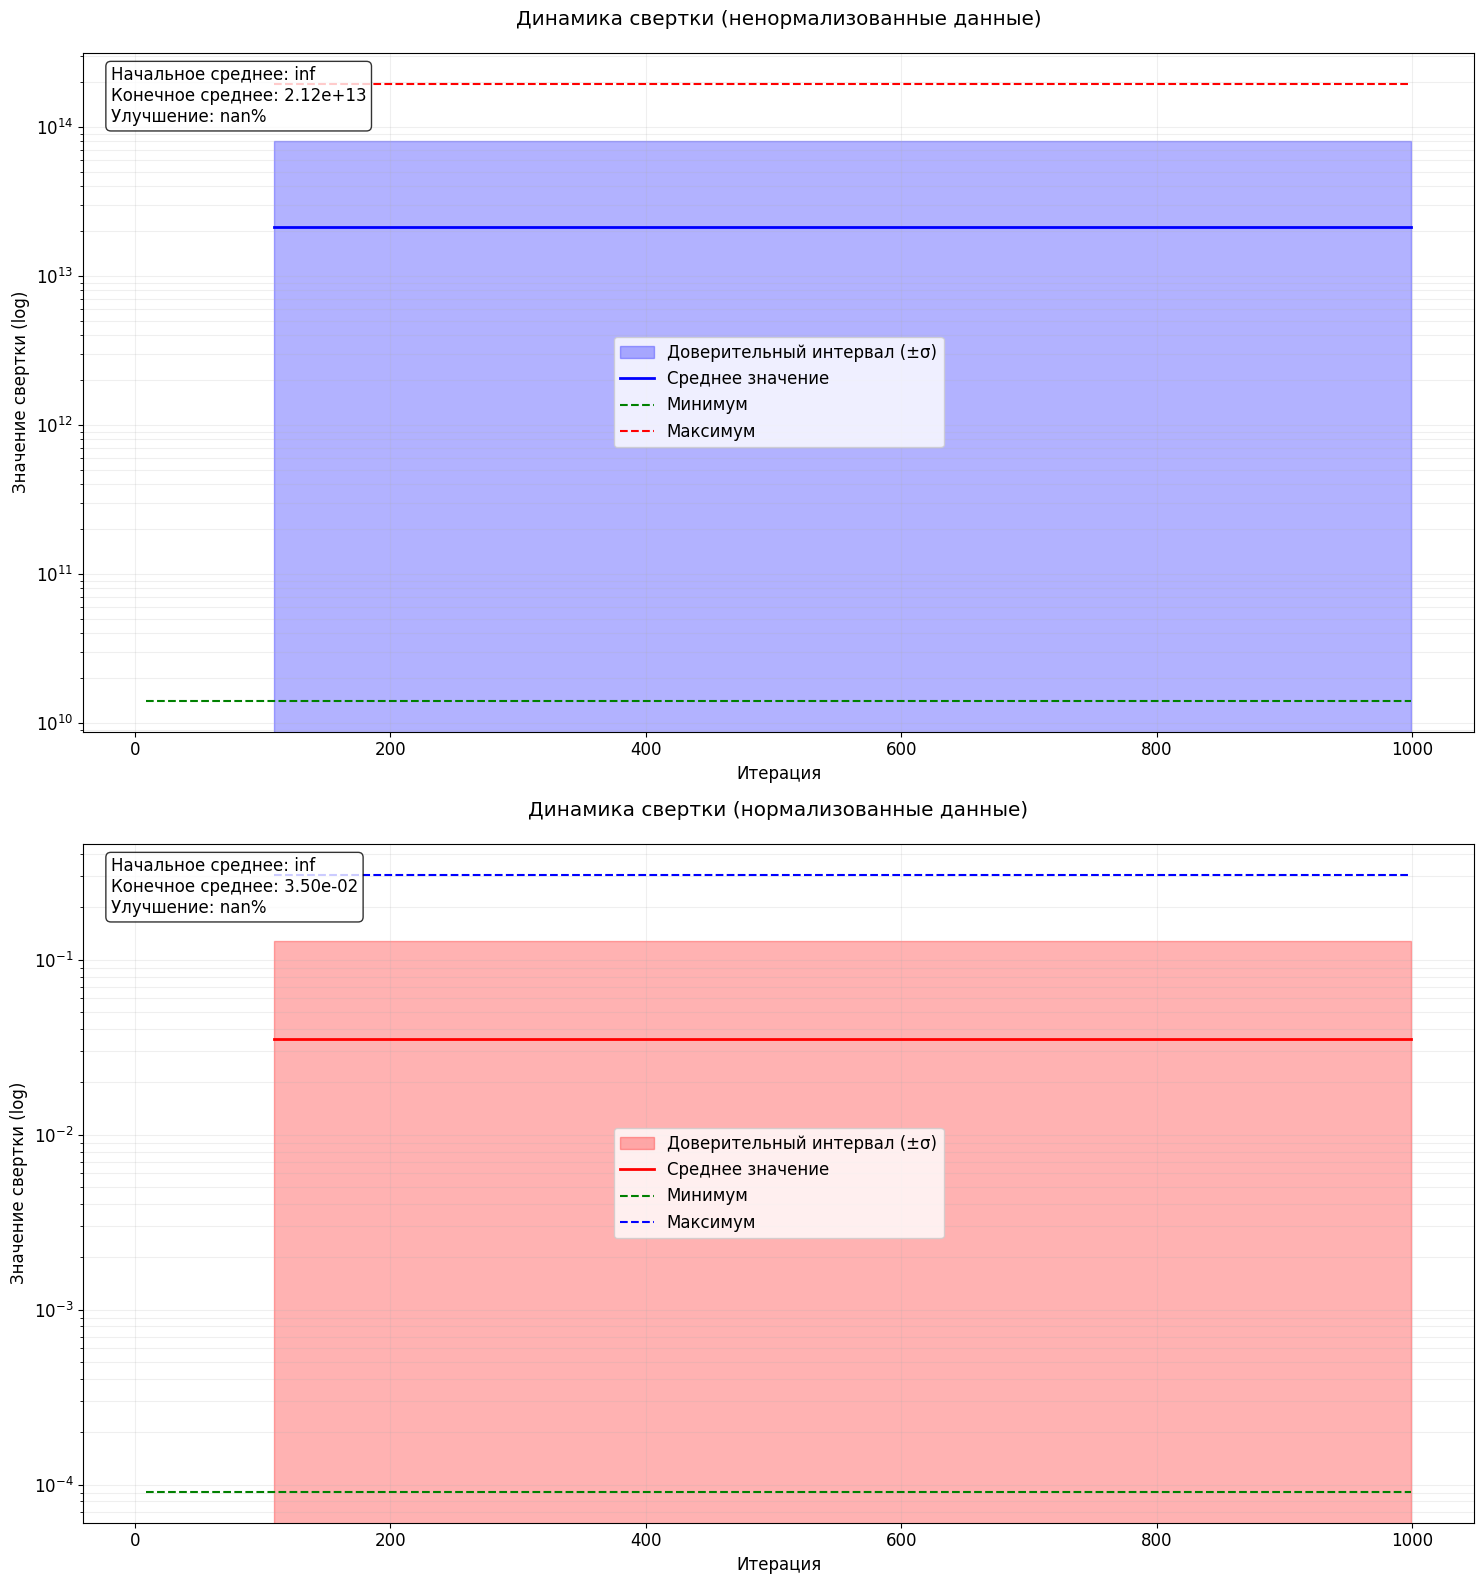

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Импорт данных
df_non_norm = pd.read_excel(r'C:\Users\meon4\Documents\MATH\Новые расчеты\data\CASE1PSO.xlsx')
df_norm = pd.read_excel(r'C:\Users\meon4\Documents\MATH\Новые расчеты\data\CASE1_normPSO.xlsx')

# Создаем фигуру с двумя графиками
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 16))

# Группировка и расчет статистик
def calculate_statistics(df):
    grouped = df.groupby('iteration')
    return pd.DataFrame({
        'mean': grouped['Свертка'].mean(),
        'std': grouped['Свертка'].std(),
        'min': grouped['Свертка'].min(),
        'max': grouped['Свертка'].max()
    }).reset_index()

stats_non_norm = calculate_statistics(df_non_norm)
stats_norm = calculate_statistics(df_norm)

# График для ненормализованной свертки
ax1.fill_between(stats_non_norm['iteration'], 
                stats_non_norm['mean'] - stats_non_norm['std'],
                stats_non_norm['mean'] + stats_non_norm['std'],
                alpha=0.3, color='blue', label='Доверительный интервал (±σ)')

ax1.plot(stats_non_norm['iteration'], stats_non_norm['mean'], 'b-', label='Среднее значение', linewidth=2)
ax1.plot(stats_non_norm['iteration'], stats_non_norm['min'], 'g--', label='Минимум', linewidth=1.5)
ax1.plot(stats_non_norm['iteration'], stats_non_norm['max'], 'r--', label='Максимум', linewidth=1.5)

ax1.set_yscale('log')
ax1.set_title('Динамика свертки (ненормализованные данные)', pad=20)
ax1.set_xlabel('Итерация')
ax1.set_ylabel('Значение свертки (log)')
ax1.grid(True, which="both", ls="-", alpha=0.2)
ax1.legend()

# Добавляем аннотацию со статистикой
initial_mean = stats_non_norm['mean'].iloc[0]
final_mean = stats_non_norm['mean'].iloc[-1]
improvement = ((initial_mean - final_mean) / initial_mean) * 100

stats_text = f'Начальное среднее: {initial_mean:.2e}\n'
stats_text += f'Конечное среднее: {final_mean:.2e}\n'
stats_text += f'Улучшение: {improvement:.2f}%'

ax1.text(0.02, 0.98, stats_text,
         transform=ax1.transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# График для нормализованной свертки
ax2.fill_between(stats_norm['iteration'], 
                stats_norm['mean'] - stats_norm['std'],
                stats_norm['mean'] + stats_norm['std'],
                alpha=0.3, color='red', label='Доверительный интервал (±σ)')

ax2.plot(stats_norm['iteration'], stats_norm['mean'], 'r-', label='Среднее значение', linewidth=2)
ax2.plot(stats_norm['iteration'], stats_norm['min'], 'g--', label='Минимум', linewidth=1.5)
ax2.plot(stats_norm['iteration'], stats_norm['max'], 'b--', label='Максимум', linewidth=1.5)

ax2.set_yscale('log')
ax2.set_title('Динамика свертки (нормализованные данные)', pad=20)
ax2.set_xlabel('Итерация')
ax2.set_ylabel('Значение свертки (log)')
ax2.grid(True, which="both", ls="-", alpha=0.2)
ax2.legend()

# Добавляем аннотацию со статистикой для нормализованных данных
initial_mean_norm = stats_norm['mean'].iloc[0]
final_mean_norm = stats_norm['mean'].iloc[-1]
improvement_norm = ((initial_mean_norm - final_mean_norm) / initial_mean_norm) * 100

stats_text_norm = f'Начальное среднее: {initial_mean_norm:.2e}\n'
stats_text_norm += f'Конечное среднее: {final_mean_norm:.2e}\n'
stats_text_norm += f'Улучшение: {improvement_norm:.2f}%'

ax2.text(0.02, 0.98, stats_text_norm,
         transform=ax2.transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Вывод дополнительной статистики
print("\nСтатистика сходимости:")
print("\nНенормализованные данные:")
print(f"Начальное среднее значение: {initial_mean:.2e}")
print(f"Конечное среднее значение: {final_mean:.2e}")
print(f"Улучшение: {improvement:.2f}%")
print(f"Стандартное отклонение в конце: {stats_non_norm['std'].iloc[-1]:.2e}")
print(f"Коэффициент вариации в конце: {(stats_non_norm['std'].iloc[-1]/final_mean):.2f}")

print("\nНормализованные данные:")
print(f"Начальное среднее значение: {initial_mean_norm:.2e}")
print(f"Конечное среднее значение: {final_mean_norm:.2e}")
print(f"Улучшение: {improvement_norm:.2f}%")
print(f"Стандартное отклонение в конце: {stats_norm['std'].iloc[-1]:.2e}")
print(f"Коэффициент вариации в конце: {(stats_norm['std'].iloc[-1]/final_mean_norm):.2f}")

# Настройка расположения графиков
plt.tight_layout()

# Сохранение результатов в Excel
results_df = pd.DataFrame({
    'Итерация': stats_non_norm['iteration'],
    'Среднее_ненорм': stats_non_norm['mean'],
    'Станд_откл_ненорм': stats_non_norm['std'],
    'Мин_ненорм': stats_non_norm['min'],
    'Макс_ненорм': stats_non_norm['max'],
    'Среднее_норм': stats_norm['mean'],
    'Станд_откл_норм': stats_norm['std'],
    'Мин_норм': stats_norm['min'],
    'Макс_норм': stats_norm['max']
})

results_df.to_excel('convolution_dynamics.xlsx', index=False)

plt.show()


c:\Users\meon4\Documents\MATH\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\meon4\Documents\MATH\.venv\Lib\site-packages\scipy\stats\_stats_py.py:1126: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean
c:\Users\meon4\Documents\MATH\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\meon4\Documents\MATH\.venv\Lib\site-packages\scipy\stats\_stats_py.py:1126: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean



Статистика распределений сохранена в файл 'distribution_analysis.xlsx'

Доступные итерации: [np.int64(9), np.int64(249), np.int64(499), np.int64(749), np.int64(999)]


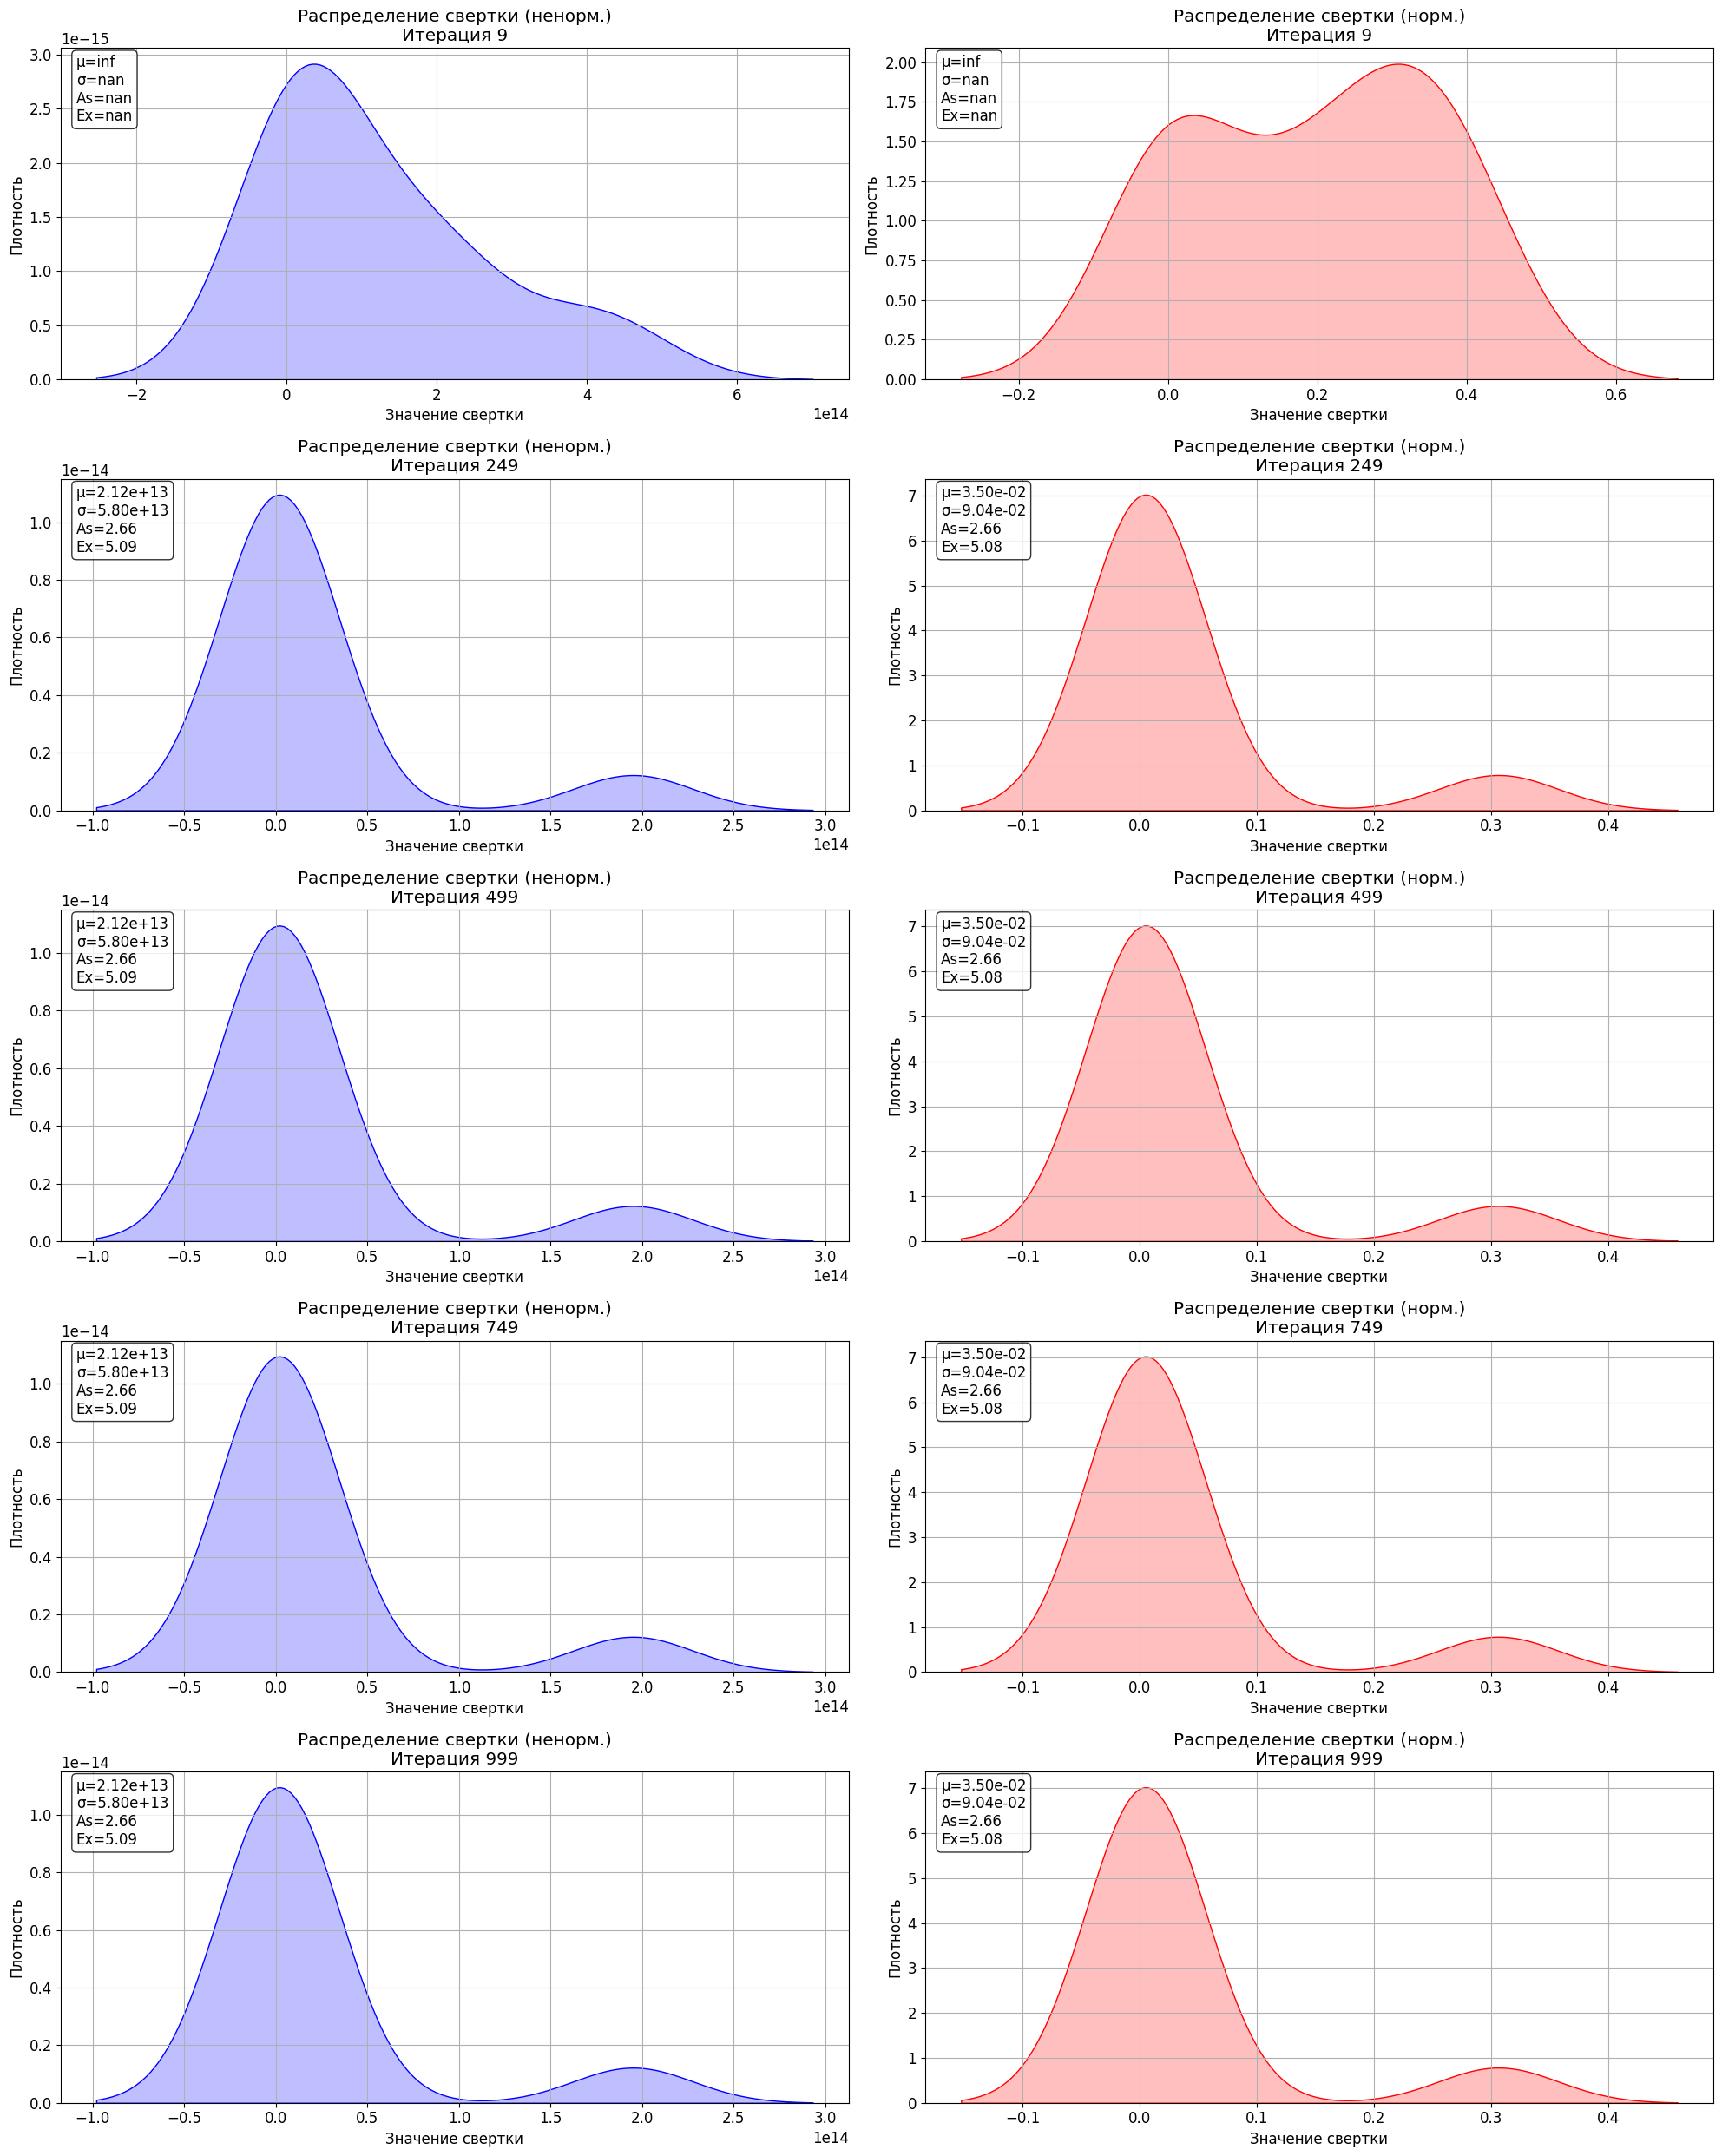

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import normaltest, skew, kurtosis

# Импорт данных
df_non_norm = pd.read_excel(r'C:\Users\meon4\Documents\MATH\Новые расчеты\data\CASE1PSO.xlsx')
df_norm = pd.read_excel(r'C:\Users\meon4\Documents\MATH\Новые расчеты\data\CASE1_normPSO.xlsx')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import normaltest, skew, kurtosis


def analyze_distribution(data, title):
    """Расширенный анализ распределения"""
    analysis = {}
    
    # Проверка на пустой набор данных
    if len(data) == 0:
        print(f"Предупреждение: Нет данных для {title}")
        return pd.Series({
            'Среднее': np.nan,
            'Медиана': np.nan,
            'Станд. отклонение': np.nan,
            'Коэф. вариации': np.nan,
            'Минимум': np.nan,
            'Максимум': np.nan,
            'Размах': np.nan,
            'Асимметрия': np.nan,
            'Эксцесс': np.nan,
            '25-й процентиль': np.nan,
            '75-й процентиль': np.nan,
            'IQR': np.nan,
            'p-value (тест на нормальность)': np.nan
        }, name=title)
    
    # Основные статистики
    analysis['Среднее'] = np.mean(data)
    analysis['Медиана'] = np.median(data)
    analysis['Станд. отклонение'] = np.std(data)
    analysis['Коэф. вариации'] = analysis['Станд. отклонение'] / analysis['Среднее']
    analysis['Минимум'] = np.min(data)
    analysis['Максимум'] = np.max(data)
    analysis['Размах'] = analysis['Максимум'] - analysis['Минимум']
    
    # Показатели формы распределения
    analysis['Асимметрия'] = skew(data)
    analysis['Эксцесс'] = kurtosis(data)
    
    # Квантили
    analysis['25-й процентиль'] = np.percentile(data, 25)
    analysis['75-й процентиль'] = np.percentile(data, 75)
    analysis['IQR'] = analysis['75-й процентиль'] - analysis['25-й процентиль']
    
    # Тест на нормальность (только если достаточно данных)
    if len(data) >= 8:  # минимальный размер выборки для теста
        stat, p_value = normaltest(data)
        analysis['p-value (тест на нормальность)'] = p_value
    else:
        analysis['p-value (тест на нормальность)'] = np.nan
    
    return pd.Series(analysis, name=title)

# Определение доступных итераций
available_iterations = sorted(df_non_norm['iteration'].unique())
if len(available_iterations) < 5:
    print("Предупреждение: недостаточно итераций для анализа")
    stages = available_iterations
else:
    # Выбираем 5 равномерно распределенных точек
    indices = np.linspace(0, len(available_iterations)-1, 5, dtype=int)
    stages = [available_iterations[i] for i in indices]

fig, axes = plt.subplots(len(stages), 2, figsize=(20, 5*len(stages)))

# Если только одна итерация, преобразуем axes в двумерный массив
if len(stages) == 1:
    axes = np.array([axes])

# Инициализация DataFrame для хранения результатов
distribution_stats = pd.DataFrame()

# Цветовая схема для графиков
colors_non_norm = 'blue'
colors_norm = 'red'

for i, stage in enumerate(stages):
    # Получение данных для текущей итерации
    data_non_norm = df_non_norm[df_non_norm['iteration'] == stage]['Свертка']
    data_norm = df_norm[df_norm['iteration'] == stage]['Свертка']
    
    # Проверка наличия данных
    if len(data_non_norm) > 0:
        stats_non_norm = analyze_distribution(data_non_norm, f'Ненорм. итерация {stage}')
        distribution_stats = pd.concat([distribution_stats, stats_non_norm.to_frame().T])
        
        # KDE график для ненормализованных данных
        sns.kdeplot(data=data_non_norm, ax=axes[i, 0], color=colors_non_norm, fill=True)
        axes[i, 0].set_title(f'Распределение свертки (ненорм.)\nИтерация {stage}')
        axes[i, 0].set_xlabel('Значение свертки')
        axes[i, 0].set_ylabel('Плотность')
        axes[i, 0].grid(True)
        
        # Добавление статистик на график
        if not np.isnan(stats_non_norm['Среднее']):
            stats_text = f'μ={stats_non_norm["Среднее"]:.2e}\n'
            stats_text += f'σ={stats_non_norm["Станд. отклонение"]:.2e}\n'
            stats_text += f'As={stats_non_norm["Асимметрия"]:.2f}\n'
            stats_text += f'Ex={stats_non_norm["Эксцесс"]:.2f}'
            
            axes[i, 0].text(0.02, 0.98, stats_text,
                          transform=axes[i, 0].transAxes,
                          verticalalignment='top',
                          bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    if len(data_norm) > 0:
        stats_norm = analyze_distribution(data_norm, f'Норм. итерация {stage}')
        distribution_stats = pd.concat([distribution_stats, stats_norm.to_frame().T])
        
        # KDE график для нормализованных данных
        sns.kdeplot(data=data_norm, ax=axes[i, 1], color=colors_norm, fill=True)
        axes[i, 1].set_title(f'Распределение свертки (норм.)\nИтерация {stage}')
        axes[i, 1].set_xlabel('Значение свертки')
        axes[i, 1].set_ylabel('Плотность')
        axes[i, 1].grid(True)
        
        # Добавление статистик на график
        if not np.isnan(stats_norm['Среднее']):
            stats_text = f'μ={stats_norm["Среднее"]:.2e}\n'
            stats_text += f'σ={stats_norm["Станд. отклонение"]:.2e}\n'
            stats_text += f'As={stats_norm["Асимметрия"]:.2f}\n'
            stats_text += f'Ex={stats_norm["Эксцесс"]:.2f}'
            
            axes[i, 1].text(0.02, 0.98, stats_text,
                          transform=axes[i, 1].transAxes,
                          verticalalignment='top',
                          bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()

# Сохранение результатов анализа
with pd.ExcelWriter('distribution_analysis.xlsx') as writer:
    distribution_stats.to_excel(writer, sheet_name='Distribution_Stats')

# Вывод основных результатов
print("\nСтатистика распределений сохранена в файл 'distribution_analysis.xlsx'")
print("\nДоступные итерации:", stages)

plt.show()

